<a href="https://colab.research.google.com/github/O-E2/deep_learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 - 비트코인 가격 예측


## 1-1 코드 옮기고 결과 제시

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import wandb
import os
import argparse
from datetime import datetime

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
SAVE_PATH = "/content/btc_krw_lstm_checkpoint.pt"

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=100)
    parser.add_argument("-r", "--learning_rate", type=float, default=1e-3)
    parser.add_argument("-w", "--weight_decay", type=float, default=1e-5)
    parser.add_argument("-v", "--validation_intervals", type=int, default=10)
    parser.add_argument("-p", "--early_stop_patience", type=int, default=30)
    parser.add_argument("-d", "--early_stop_delta", type=float, default=0.000001)
    return parser

class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]['Close'])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])

class MyLSTM(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(n_input, 128, num_layers=2, batch_first=True)
        self.fcn = nn.Linear(128, n_output)
    def forward(self, x):
        x, _ = self.lstm(x)
        return self.fcn(x[:, -1, :])

def main(args):
    run = wandb.init(
        project="btc_krw_lstm",
        config=vars(args),
        name=datetime.now().strftime('%m%d_%H%M'),
        mode="online" if args.wandb else "disabled"
    )

    print(f"\nWandB Run URL: {run.get_url() if args.wandb else 'Disabled'}\n")

    X_train, X_val, _, y_train, y_val, _ = get_btc_krw_data()
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyLSTM(5, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    loss_fn = nn.MSELoss()

    for epoch in range(args.epochs):
        model.train()
        t_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X).squeeze()
            loss = loss_fn(pred, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            t_loss += loss.item()

        model.eval()
        v_loss = 0
        with torch.no_grad():
            for v_X, v_y in val_loader:
                v_X, v_y = v_X.to(device), v_y.to(device)
                v_loss += loss_fn(model(v_X).squeeze(), v_y).item()

        avg_t, avg_v = t_loss/len(train_loader), v_loss/len(val_loader)

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{args.epochs} | Train Loss: {avg_t:.6f} | Val Loss: {avg_v:.6f}")

        wandb.log({"train_loss": avg_t, "val_loss": avg_v})

    torch.save(model.state_dict(), SAVE_PATH)
    print(f"\nModel saved to {SAVE_PATH}")
    print(f"Final URL: {run.get_url() if args.wandb else 'N/A'}")
    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


WandB Run URL: None

Epoch   1/100 | Train Loss: 7.505772 | Val Loss: 30.974534
Epoch  10/100 | Train Loss: 0.050993 | Val Loss: 0.472318
Epoch  20/100 | Train Loss: 0.029345 | Val Loss: 0.492033
Epoch  30/100 | Train Loss: 0.024922 | Val Loss: 0.191368
Epoch  40/100 | Train Loss: 0.023676 | Val Loss: 0.160476
Epoch  50/100 | Train Loss: 0.032473 | Val Loss: 0.218565
Epoch  60/100 | Train Loss: 0.021392 | Val Loss: 0.143248
Epoch  70/100 | Train Loss: 0.034341 | Val Loss: 0.275819
Epoch  80/100 | Train Loss: 0.019715 | Val Loss: 0.163980
Epoch  90/100 | Train Loss: 0.020674 | Val Loss: 0.124117
Epoch 100/100 | Train Loss: 0.019415 | Val Loss: 0.202387

Model saved to /content/btc_krw_lstm_checkpoint.pt
Final URL: None


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.01942
val_loss,0.20239


## 1-1 결과 제시
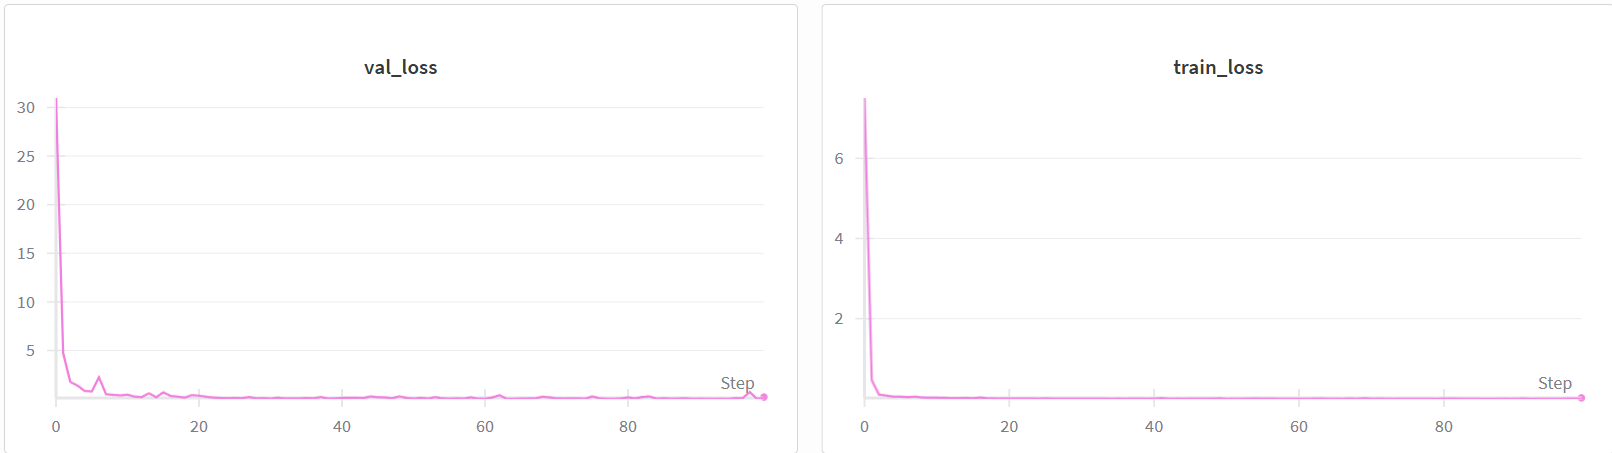
[wandb URL](https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm/runs/2hkm71kh)

텍스트 - https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm/runs/2hkm71kh

## 1-2 코드 옮기고 결과 제시

MODEL FILE: /content/btc_krw_lstm_checkpoint.pt

[TEST DATA PREDICTION]
 0: Pred:  128,364,439 | Target:  125,060,339 | AbsErr:    3,304,100
 1: Pred:  121,896,515 | Target:  124,410,229 | AbsErr:    2,513,714
 2: Pred:  123,570,461 | Target:  127,580,166 | AbsErr:    4,009,705
 3: Pred:  126,106,205 | Target:  130,283,813 | AbsErr:    4,177,608
 4: Pred:  127,650,032 | Target:  128,044,958 | AbsErr:      394,926
 5: Pred:  127,025,518 | Target:  133,208,456 | AbsErr:    6,182,938
 6: Pred:  130,282,679 | Target:  133,495,436 | AbsErr:    3,212,757
 7: Pred:  131,483,212 | Target:  133,435,850 | AbsErr:    1,952,639
 8: Pred:  131,708,832 | Target:  133,336,763 | AbsErr:    1,627,932
 9: Pred:  129,663,782 | Target:  132,669,859 | AbsErr:    3,006,077

[TEST METRICS] MAE(KRW)=3,038,239 | MSE(KRW^2)=11,497,192,707,566 | RMSE(KRW)=3,390,751


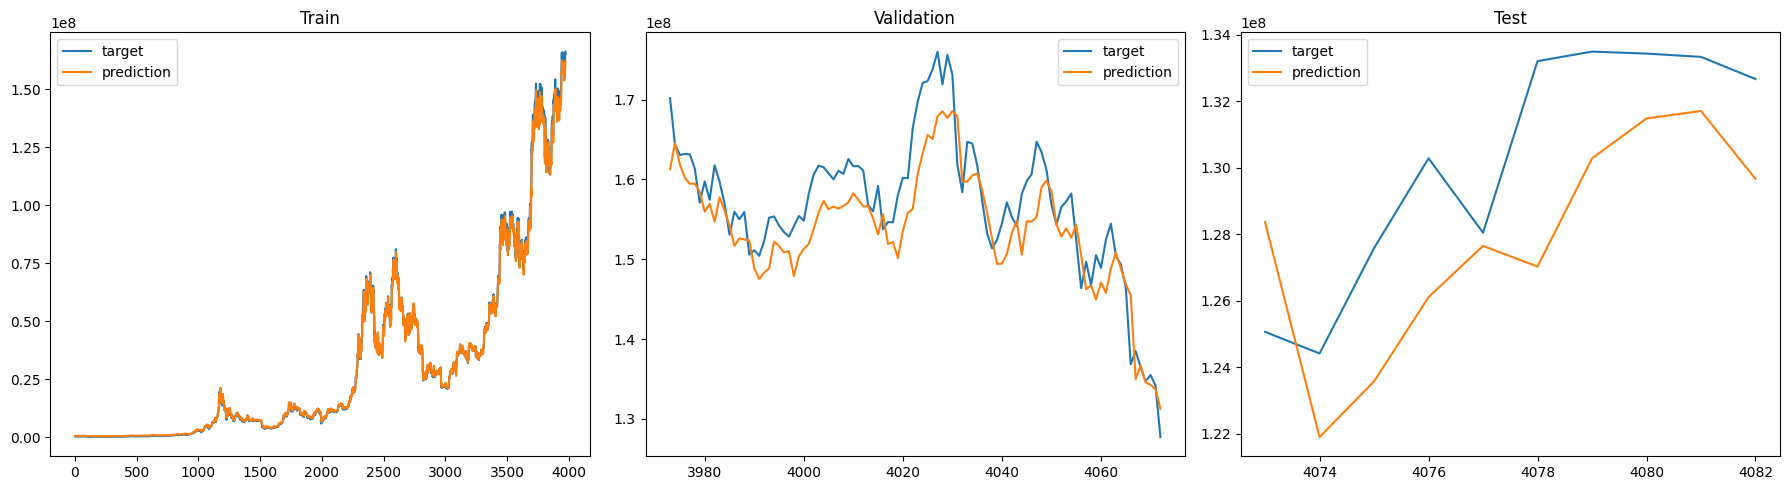

In [60]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import wandb
from datetime import datetime

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
CHECKPOINT_PATH = "/content/btc_krw_lstm_checkpoint.pt"

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False)
    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=100)
    parser.add_argument("-r", "--learning_rate", type=float, default=1e-3)
    parser.add_argument("-w", "--weight_decay", type=float, default=1e-5)
    parser.add_argument("-v", "--validation_intervals", type=int, default=10)
    parser.add_argument("-p", "--early_stop_patience", type=int, default=30)
    parser.add_argument("-d", "--early_stop_delta", type=float, default=0.000001)
    return parser

class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]['Close'])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])

class MyLSTM(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(n_input, 128, num_layers=2, batch_first=True)
        self.fcn = nn.Linear(128, n_output)
    def forward(self, x):
        x, _ = self.lstm(x)
        return self.fcn(x[:, -1, :])

def test(test_model, X_test, y_test):
    test_model.eval()
    y_normalizer = 1.0e7

    print("\n[TEST DATA PREDICTION]")
    abs_err_list = []
    sq_err_list = []

    with torch.no_grad():
        output_test = test_model(X_test).squeeze(-1)

        for idx, (output, target) in enumerate(zip(output_test, y_test)):
            out_val = output.item() * y_normalizer
            tar_val = target.item() * y_normalizer

            err = out_val - tar_val
            abs_err = abs(err)
            sq_err = err * err

            abs_err_list.append(abs_err)
            sq_err_list.append(sq_err)

            print(
                f"{idx:2}: Pred: {out_val:12,.0f} | Target: {tar_val:12,.0f} | "
                f"AbsErr: {abs_err:12,.0f}"
            )

    mae = float(np.mean(abs_err_list))
    mse = float(np.mean(sq_err_list))
    rmse = float(np.sqrt(mse))

    print(f"\n[TEST METRICS] MAE(KRW)={mae:,.0f} | MSE(KRW^2)={mse:,.0f} | RMSE(KRW)={rmse:,.0f}")



def predict_all(test_model, datasets):
    test_model.eval()
    y_normalizer = 1.0e7
    labels = ["Train", "Validation", "Test"]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    current_idx = 0
    for i, (X, y) in enumerate(datasets):
        with torch.no_grad():
            prediction = test_model(X).squeeze().numpy() * y_normalizer
            target = y.numpy() * y_normalizer
            X_axis = np.arange(current_idx, current_idx + len(target))
            axs[i].plot(X_axis, target, label='target')
            axs[i].plot(X_axis, prediction, label='prediction')
            axs[i].set_title(labels[i])
            axs[i].legend()
            current_idx += len(target)
    plt.tight_layout()
    plt.show()

def main(args):
    wandb.init(project="btc_krw_lstm_test", config=vars(args), mode="disabled")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyLSTM(5, 1).to(device)

    if os.path.exists(CHECKPOINT_PATH):
        model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
        print(f"MODEL FILE: {CHECKPOINT_PATH}")

    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data()

    test(model, X_test.to(device), y_test)
    predict_all(model.cpu(), [(X_train, y_train), (X_val, y_val), (X_test, y_test)])
    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)

## 1-2 결과 제시 및 그래프
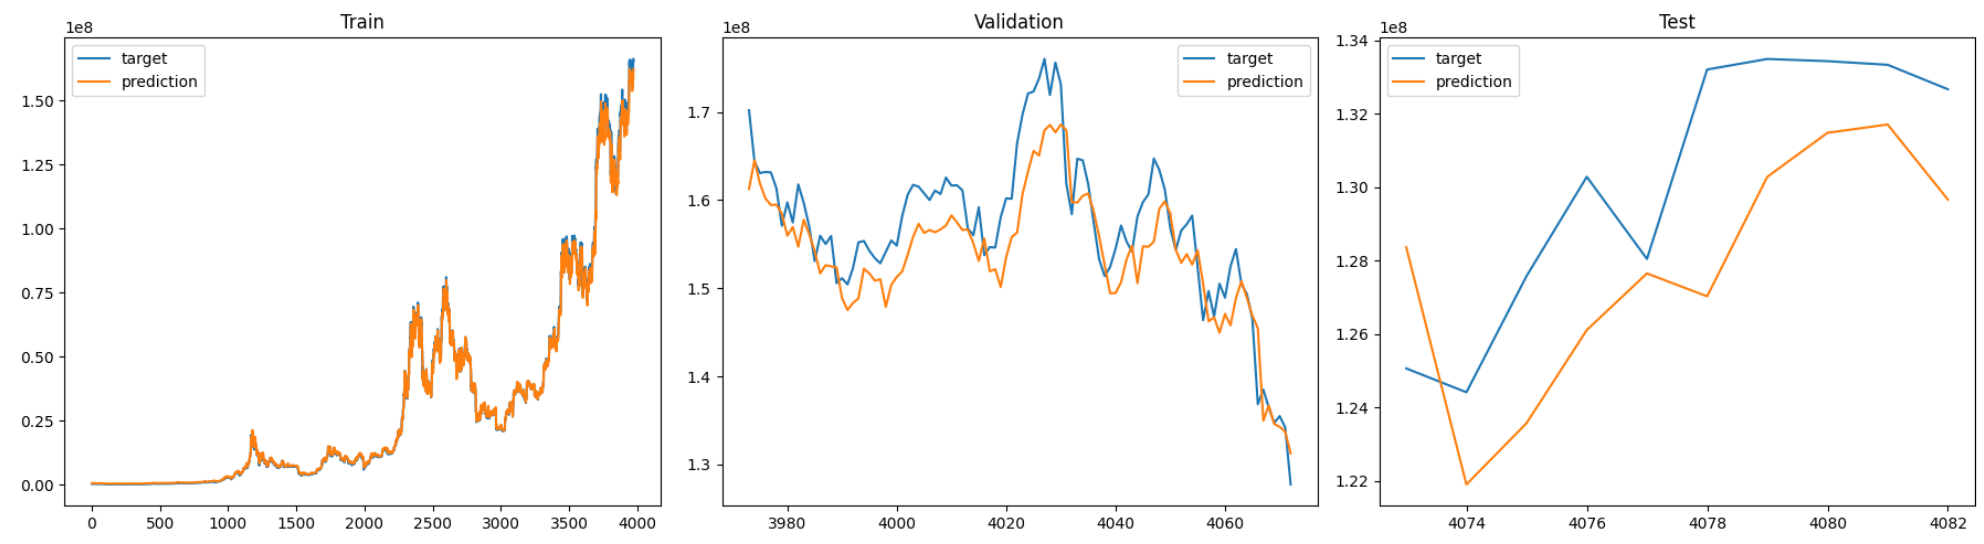


## 1-3 코드 옮기고 결과 제시하기

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import wandb
import os
import argparse
from datetime import datetime

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
SAVE_PATH = "/content/btc_krw_lstm_classification_checkpoint.pt"

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=100)
    parser.add_argument("-r", "--learning_rate", type=float, default=1e-4)
    parser.add_argument("-w", "--weight_decay", type=float, default=1e-5)
    parser.add_argument("-v", "--validation_intervals", type=int, default=10)
    parser.add_argument("-p", "--early_stop_patience", type=int, default=100)
    return parser

class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        # 분류: 다음날 종가가 오늘 종가보다 크거나 같으면 1, 아니면 0
        target = 1 if df_numeric.iloc[i + sequence_size]['Close'] >= df_numeric.iloc[i + sequence_size - 1]['Close'] else 0
        y_list.append(target)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])

class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
        self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fcn(x)

def main(args):
    run = wandb.init(
        project="lstm_classification_btc_krw",
        config=vars(args),
        name=datetime.now().strftime('%m%d_%H%M'),
        mode="online" if args.wandb else "disabled"
    )

    print(f"\nWandB URL: {run.get_url() if args.wandb else 'N/A'}\n")

    X_train, X_val, _, y_train, y_val, _ = get_btc_krw_data()
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(n_input=5, n_output=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(args.epochs):
        model.train()
        t_loss, t_correct = 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X)
            loss = loss_fn(pred, batch_y)

            optimizer.zero_grad(); loss.backward(); optimizer.step()

            t_loss += loss.item()
            t_correct += (pred.argmax(1) == batch_y).type(torch.float).sum().item()

        model.eval()
        v_loss, v_correct = 0, 0
        with torch.no_grad():
            for v_X, v_y in val_loader:
                v_X, v_y = v_X.to(device), v_y.to(device)
                v_pred = model(v_X)
                v_loss += loss_fn(v_pred, v_y).item()
                v_correct += (v_pred.argmax(1) == v_y).type(torch.float).sum().item()

        avg_t_loss, t_acc = t_loss/len(train_loader), t_correct/len(X_train)
        avg_v_loss, v_acc = v_loss/len(val_loader), v_correct/len(X_val)

        if (epoch + 1) % args.validation_intervals == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Acc: {t_acc:.4f} Loss: {avg_t_loss:.6f} | Val Acc: {v_acc:.4f} Loss: {avg_v_loss:.6f}")

        wandb.log({"train_acc": t_acc, "train_loss": avg_t_loss, "val_acc": v_acc, "val_loss": avg_v_loss})

    torch.save(model.state_dict(), SAVE_PATH)
    print(f"\nModel Saved: {SAVE_PATH}")
    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


WandB URL: None

Epoch   1 | Train Acc: 0.5266 Loss: 0.692203 | Val Acc: 0.5300 Loss: 0.692972
Epoch  10 | Train Acc: 0.5263 Loss: 0.692189 | Val Acc: 0.5400 Loss: 0.690689
Epoch  20 | Train Acc: 0.5250 Loss: 0.690846 | Val Acc: 0.5400 Loss: 0.691686
Epoch  30 | Train Acc: 0.5273 Loss: 0.691725 | Val Acc: 0.5400 Loss: 0.691897
Epoch  40 | Train Acc: 0.5281 Loss: 0.690273 | Val Acc: 0.5400 Loss: 0.692023
Epoch  50 | Train Acc: 0.5233 Loss: 0.691270 | Val Acc: 0.5400 Loss: 0.691129
Epoch  60 | Train Acc: 0.5283 Loss: 0.691145 | Val Acc: 0.5400 Loss: 0.691657
Epoch  70 | Train Acc: 0.5296 Loss: 0.690961 | Val Acc: 0.5600 Loss: 0.692635
Epoch  80 | Train Acc: 0.5278 Loss: 0.691601 | Val Acc: 0.5100 Loss: 0.692015
Epoch  90 | Train Acc: 0.5248 Loss: 0.691046 | Val Acc: 0.5400 Loss: 0.691325
Epoch 100 | Train Acc: 0.5263 Loss: 0.690939 | Val Acc: 0.5300 Loss: 0.691705

Model Saved: /content/btc_krw_lstm_classification_checkpoint.pt


train_acc,▅▄▅▄▄█▆▅▆▇▅▆▂▃▅▄▇▅▄▅▅▆▅▁▃▇▆▅▆▅▁▄▆▅▅██▄▅▅
train_loss,▅▄▇▅▆▃▆▃▄▆▃▄▅▃▆▄▁▅▇▄▅█▅▆▆▃▅▃▁▄▄▅▅▆▇▇▅▄▂▄
val_acc,▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▂▄▅▃▄▇▆▁▇▂█
val_loss,█▃▃▃▃▂▃▃▅▅▄▃▄▃▁▄▄▃▆▄▂▄▄▅▅▂▄▅▄▆▅▆▄█▆█▅▄▇▅
train_acc,0.5263
train_loss,0.69094
val_acc,0.53
val_loss,0.69171


## 1-3 결과
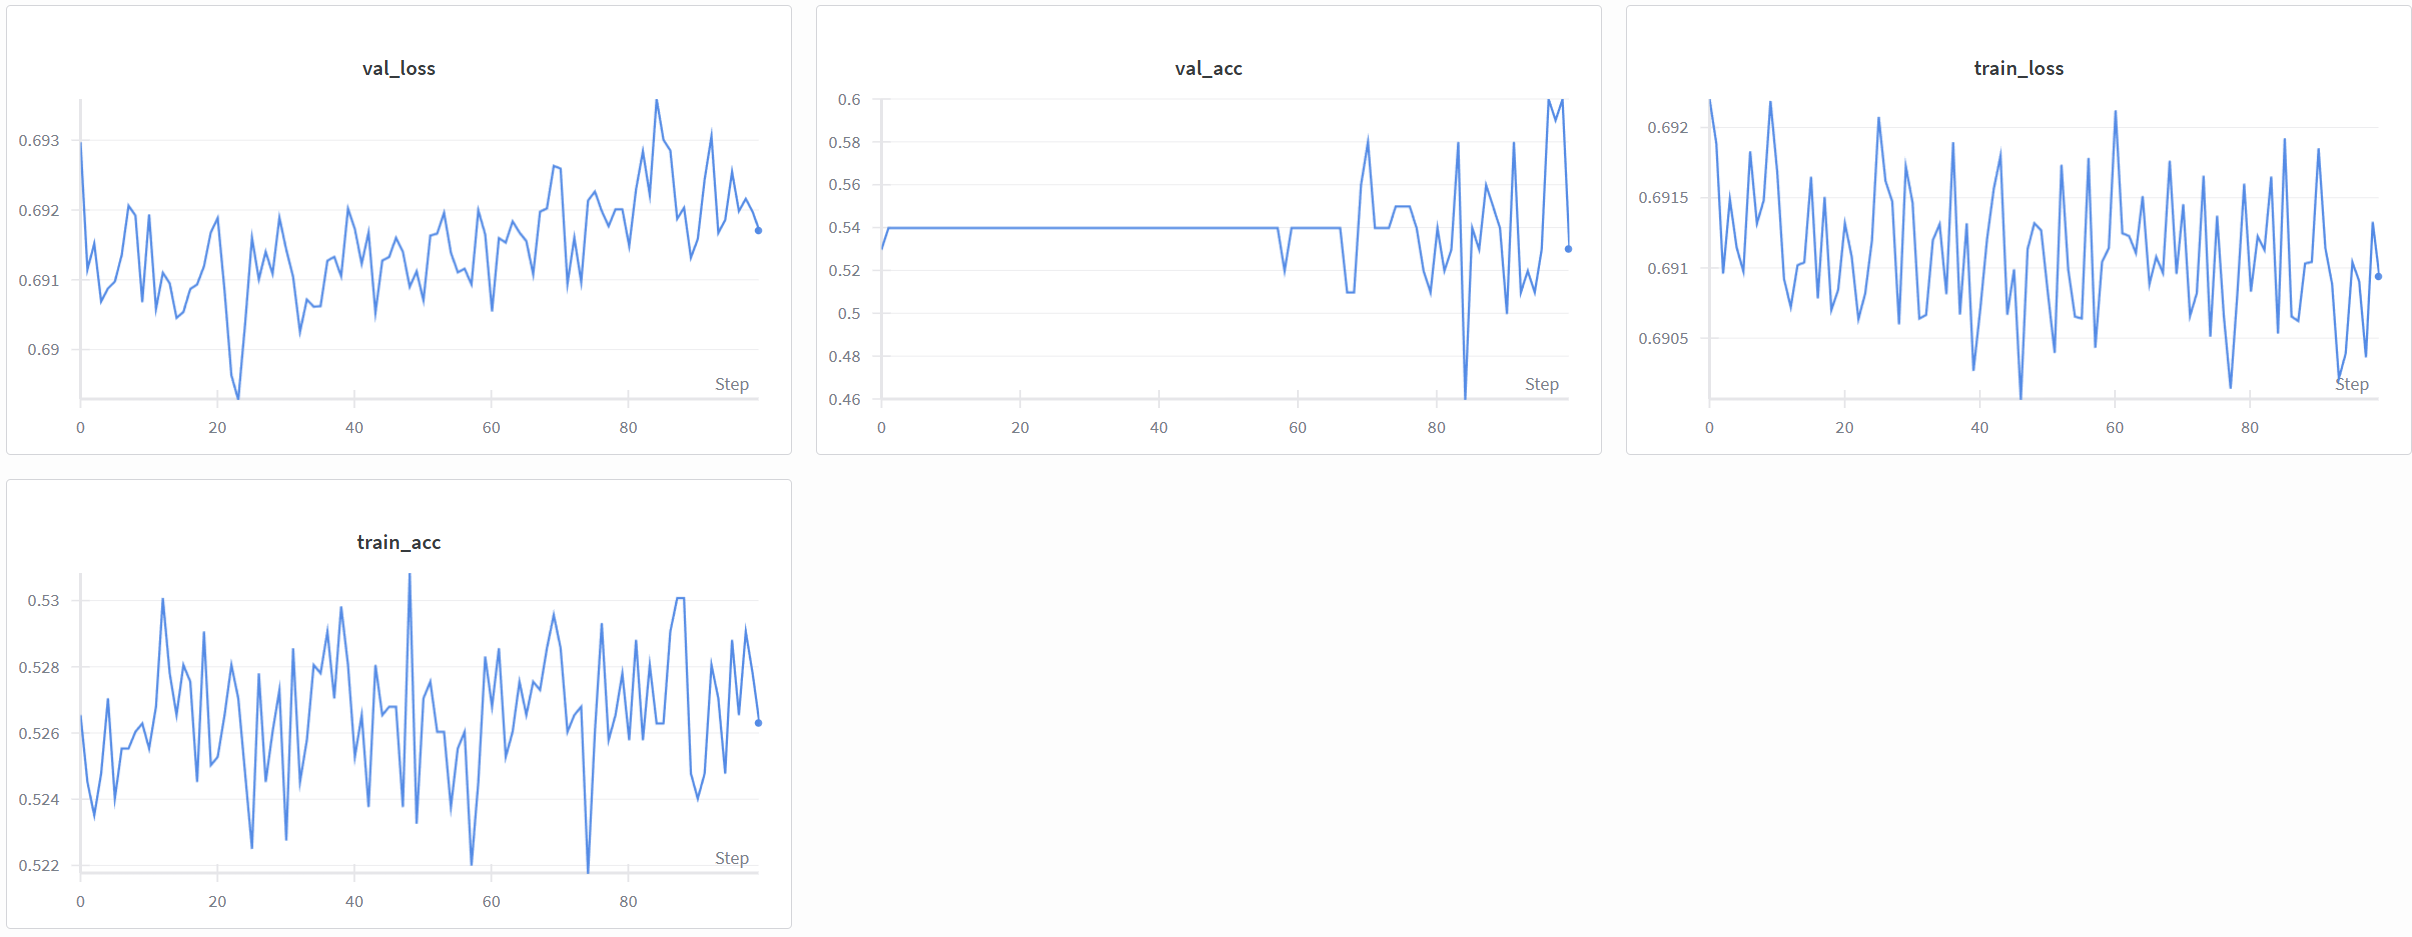

[wandb URL](https://wandb.ai/cyun0407-korea-university-of-technology-and-education/lstm_classification_btc_krw/runs/hj4ftgqw)

텍스트 - https://wandb.ai/cyun0407-korea-university-of-technology-and-education/lstm_classification_btc_krw/runs/hj4ftgqw

## 1-4 코드 옮기고 결과 제시하기

In [21]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import argparse
import wandb
from datetime import datetime

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
CHECKPOINT_PATH = "/content/btc_krw_lstm_classification_checkpoint.pt"

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False)
    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=100)
    parser.add_argument("-r", "--learning_rate", type=float, default=1e-4)
    return parser

class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        target = 1 if df_numeric.iloc[i + sequence_size]['Close'] >= df_numeric.iloc[i + sequence_size - 1]['Close'] else 0
        y_list.append(target)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])

class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
        self.fcn = nn.Linear(in_features=256, out_features=n_output)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fcn(x)

def test(test_model, X_test, y_test):
    test_model.eval()
    num_corrects = 0

    print("[TEST DATA]")
    with torch.no_grad():
        output_test = test_model(X_test)
        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects = torch.sum(torch.eq(predicted_test, y_test)).item()

        test_accuracy = 100.0 * num_corrects / len(y_test)
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")
        print("\n[SAMPLE COMPARISON (Pred <--> Target)]")
        for idx, (pred, target) in enumerate(zip(predicted_test, y_test)):
            print(f"{idx:2}: {pred.item()} <--> {target.item()}")

def main(args):
    wandb.init(project="lstm_classification_btc_krw_test", mode="disabled")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(n_input=5, n_output=2).to(device)

    if os.path.exists(CHECKPOINT_PATH):
        model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
        print(f"MODEL FILE: {CHECKPOINT_PATH}")
    else:
        print("체크포인트 파일 없음")

    _, _, X_test, _, _, y_test = get_btc_krw_data()

    test(model, X_test.to(device), y_test.to(device))
    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)

MODEL FILE: /content/btc_krw_lstm_classification_checkpoint.pt
[TEST DATA]
TEST RESULTS: 60.000%

[SAMPLE COMPARISON (Pred <--> Target)]
 0: 0 <--> 0
 1: 0 <--> 0
 2: 0 <--> 1
 3: 0 <--> 1
 4: 0 <--> 0
 5: 0 <--> 1
 6: 0 <--> 1
 7: 0 <--> 0
 8: 0 <--> 0
 9: 0 <--> 0


## 1-4 결과
테스트 결과 60% 정답률을 보인다.

## 2-1 Regression 모델 구성 비교
최적 구성: "lstm_layers": 2, "linear_layers": 3, "dropout": 0.1, "weight_decay": 1e-5

[wandb](https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm_regression_compare)

텍스트: https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm_regression_compare

WandB URL: None
[Compare-4: propriety] Epoch   1 | train_loss=5.755644 | val_loss=1.340750
[Compare-4: propriety] Epoch  20 | train_loss=0.094006 | val_loss=0.431964
[Compare-4: propriety] Epoch  40 | train_loss=0.068521 | val_loss=0.213609
[Compare-4: propriety] Epoch  60 | train_loss=0.066477 | val_loss=0.277717
[Compare-4: propriety] Epoch  80 | train_loss=0.066090 | val_loss=0.507643
[Compare-4: propriety] Epoch 100 | train_loss=0.065500 | val_loss=0.109168
[Compare-4: propriety] Epoch 120 | train_loss=0.072853 | val_loss=1.150377
[Compare-4: propriety] Epoch 140 | train_loss=0.061760 | val_loss=0.281361
[Compare-4: propriety] Epoch 160 | train_loss=0.071531 | val_loss=0.123556
[Compare-4: propriety] Epoch 180 | train_loss=0.068233 | val_loss=0.112820
[Compare-4: propriety] Epoch 200 | train_loss=0.051854 | val_loss=0.108733


best_val_loss,▁
best_val_loss_so_far,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▄▃▂▃▄▂▂▂▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▁▃▂▂▂▂▂▂▂▁▂▁▁▂▂▁
val_loss,▆▇▂▂▅█▅▂▁▁▁▃▂▁▆▁▂▂▄▂▄▃▃▃▂▂▁▁▁▁▂▂▁▂▂▄▂▄▂▁
best_val_loss,0.09643
best_val_loss_so_far,0.09643
epoch,200
model_path,/content/model_Compa...
train_loss,0.05185
val_loss,0.10873



[Compare-4: propriety] best_val_loss=0.096428


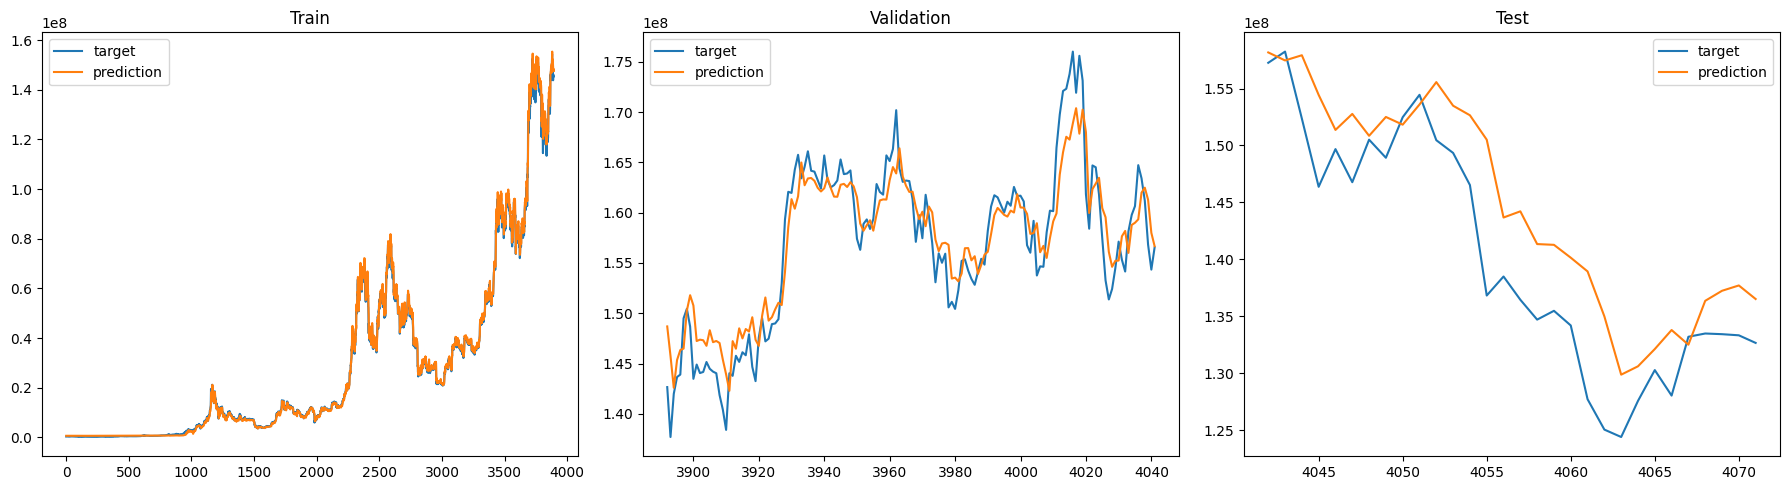

WandB URL: None
[Compare-1: high-drop] Epoch   1 | train_loss=5.621871 | val_loss=0.584796
[Compare-1: high-drop] Epoch  20 | train_loss=0.232127 | val_loss=0.797368
[Compare-1: high-drop] Epoch  40 | train_loss=0.169398 | val_loss=0.832550
[Compare-1: high-drop] Epoch  60 | train_loss=0.148611 | val_loss=0.186595
[Compare-1: high-drop] Epoch  80 | train_loss=0.138296 | val_loss=0.174261
[Compare-1: high-drop] Epoch 100 | train_loss=0.134621 | val_loss=1.105322
[Compare-1: high-drop] Epoch 120 | train_loss=0.118229 | val_loss=0.150066
[Compare-1: high-drop] Epoch 140 | train_loss=0.126972 | val_loss=0.158390
[Compare-1: high-drop] Epoch 160 | train_loss=0.139475 | val_loss=0.714794
[Compare-1: high-drop] Epoch 180 | train_loss=0.110496 | val_loss=0.218309
[Compare-1: high-drop] Epoch 200 | train_loss=0.106016 | val_loss=0.171924


best_val_loss,▁
best_val_loss_so_far,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▆▂▁▂▂▁▂▅▁▃▁▃▂▂▃▁▁█▂▁▁▁▅▄▂▁▂▁▃▁▁▃▃▁▁▁▂▁▁
best_val_loss,0.12767
best_val_loss_so_far,0.12767
epoch,200
model_path,/content/model_Compa...
train_loss,0.10602
val_loss,0.17192



[Compare-1: high-drop] best_val_loss=0.127669


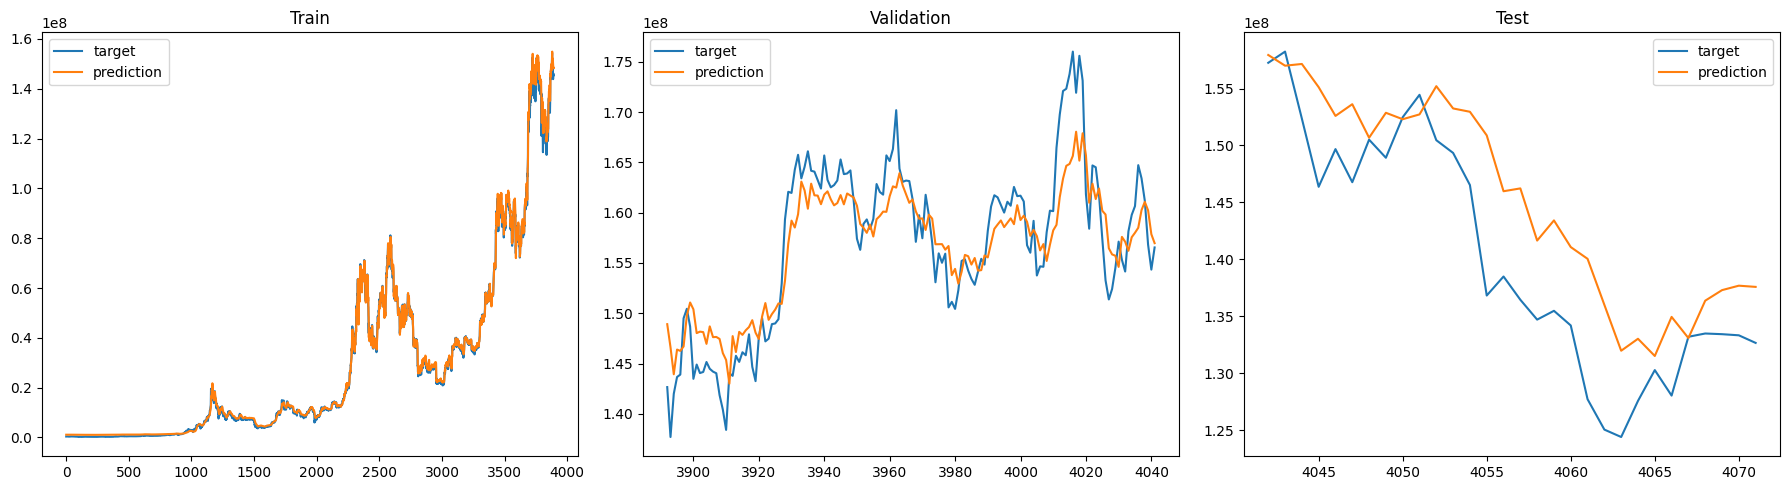

WandB URL: None
[Compare-2: low-linear] Epoch   1 | train_loss=5.742590 | val_loss=28.874238
[Compare-2: low-linear] Epoch  20 | train_loss=0.040686 | val_loss=0.938613
[Compare-2: low-linear] Epoch  40 | train_loss=0.028825 | val_loss=0.332157
[Compare-2: low-linear] Epoch  60 | train_loss=0.026610 | val_loss=0.508189
[Compare-2: low-linear] Epoch  80 | train_loss=0.025692 | val_loss=0.397990
[Compare-2: low-linear] Epoch 100 | train_loss=0.026776 | val_loss=0.941282
[Compare-2: low-linear] Epoch 120 | train_loss=0.022851 | val_loss=0.366856
[Compare-2: low-linear] Epoch 140 | train_loss=0.023034 | val_loss=0.323394
[Compare-2: low-linear] Epoch 160 | train_loss=0.023892 | val_loss=0.371944
[Compare-2: low-linear] Epoch 180 | train_loss=0.023046 | val_loss=0.545872
[Compare-2: low-linear] Epoch 200 | train_loss=0.022262 | val_loss=0.640861


best_val_loss,▁
best_val_loss_so_far,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
train_loss,█▅▅▅▄▃▃▄▂▂▂▂▁▂▂▂▃▂▁▂▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_loss,█▇▅▅▅▃▄▄▂▃▂▃▄▂▂▁▂▂▂▅▂▃▁▁▁▃▂▂▁▂▃▁▂▂▂▂▁▁▂▂
best_val_loss,0.16614
best_val_loss_so_far,0.16614
epoch,200
model_path,/content/model_Compa...
train_loss,0.02226
val_loss,0.64086



[Compare-2: low-linear] best_val_loss=0.166141


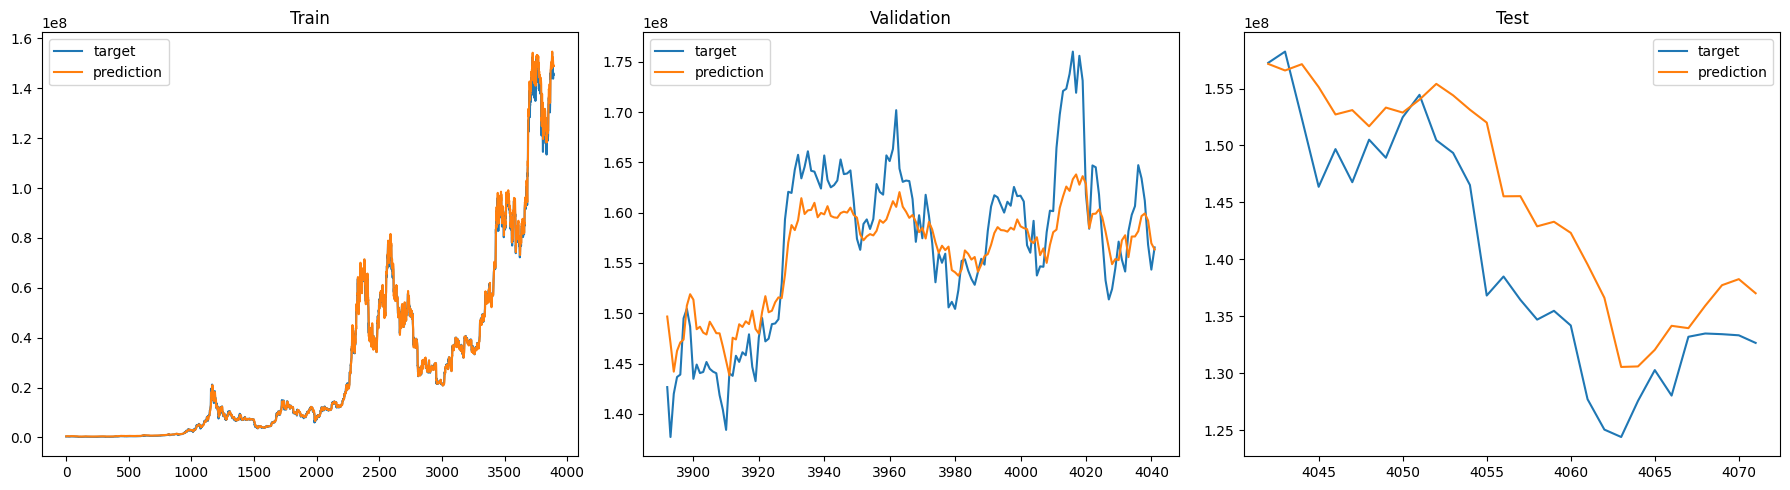

WandB URL: None
[Compare-3: low-L2] Epoch   1 | train_loss=5.695001 | val_loss=0.431360
[Compare-3: low-L2] Epoch  20 | train_loss=0.079550 | val_loss=0.191761
[Compare-3: low-L2] Epoch  40 | train_loss=0.077794 | val_loss=0.462977
[Compare-3: low-L2] Epoch  60 | train_loss=0.071743 | val_loss=0.502899
[Compare-3: low-L2] Epoch  80 | train_loss=0.067978 | val_loss=0.801491
[Compare-3: low-L2] Epoch 100 | train_loss=0.068740 | val_loss=0.119266
[Compare-3: low-L2] Epoch 120 | train_loss=0.067917 | val_loss=0.119015
[Compare-3: low-L2] Epoch 140 | train_loss=0.054961 | val_loss=0.249711
[Compare-3: low-L2] Epoch 160 | train_loss=0.057995 | val_loss=0.357145
[Compare-3: low-L2] Epoch 180 | train_loss=0.056020 | val_loss=0.482046
[Compare-3: low-L2] Epoch 200 | train_loss=0.064748 | val_loss=0.327733


best_val_loss,▁
best_val_loss_so_far,██▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▄▄▄▃▂▃▃▂▂▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁
val_loss,▃▆▁▃▂▁▇▃▁▁▁▂▁▁▁▁▂▃▂▄▁▄▁▃▁▃▁▁▃█▁▂▂▁▁▁▁▁▃▂
best_val_loss,0.10178
best_val_loss_so_far,0.10178
epoch,200
model_path,/content/model_Compa...
train_loss,0.06475
val_loss,0.32773



[Compare-3: low-L2] best_val_loss=0.101776


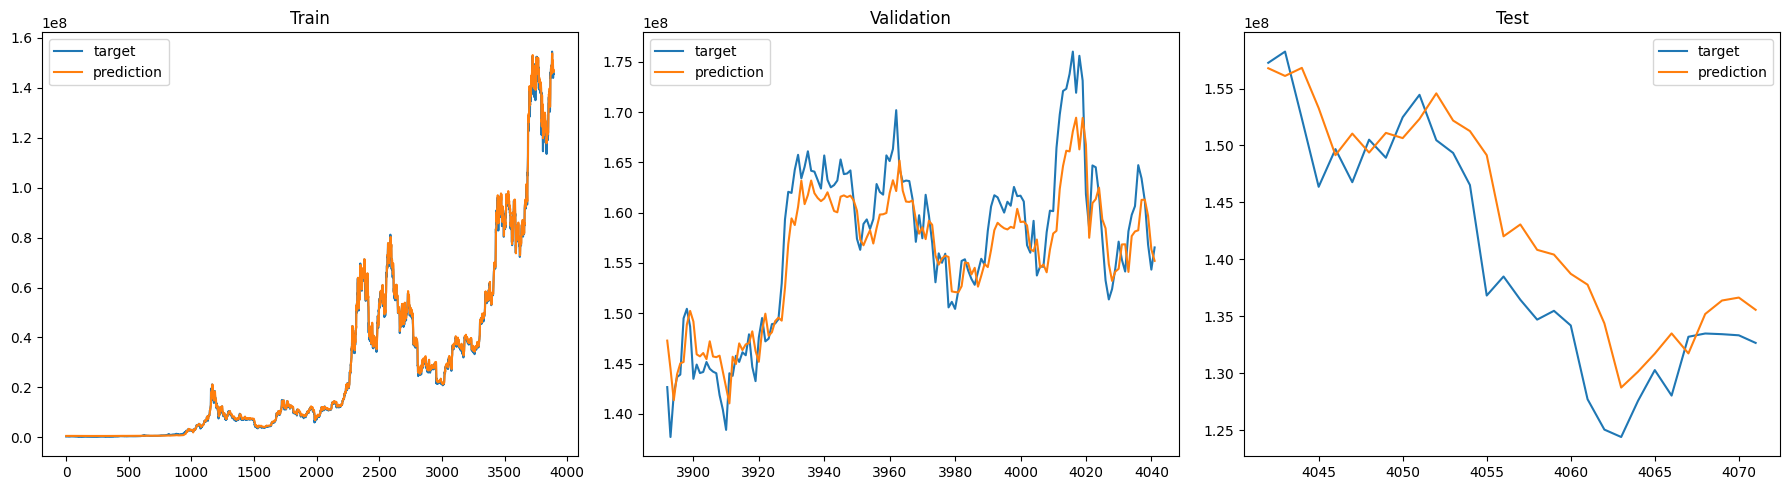


################################################################################
BEST MODEL (Regression)
Name         : Compare-4: propriety
Best Val Loss: 0.096428
Model Path   : /content/model_Compare-4_propriety.pt
################################################################################


In [34]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30
IS_REGRESSION = True

HIDDEN_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 5e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i:i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]['Close'])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class MyLSTM(nn.Module):
    def __init__(self, n_input, n_output, hidden_size, lstm_layers, linear_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        layers = []
        for _ in range(max(0, linear_layers - 1)):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
        layers.append(nn.Linear(hidden_size, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


def predict_all(test_model, datasets):
    test_model.eval()
    y_normalizer = 1.0e7
    labels = ["Train", "Validation", "Test"]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    current_idx = 0
    for i, (X, y) in enumerate(datasets):
        X = X.to(DEVICE)
        with torch.no_grad():
            prediction = test_model(X).squeeze().detach().cpu().numpy() * y_normalizer
            target = y.detach().cpu().numpy() * y_normalizer
            X_axis = np.arange(current_idx, current_idx + len(target))
            axs[i].plot(X_axis, target, label='target')
            axs[i].plot(X_axis, prediction, label='prediction')
            axs[i].set_title(labels[i])
            axs[i].legend()
            current_idx += len(target)
    plt.tight_layout()
    plt.show()


def train_model(config, X_train, y_train, X_val, y_val, save_path=None, use_wandb=False):
    model = MyLSTM(
        5, 1, HIDDEN_SIZE,
        config["lstm_layers"], config["linear_layers"], config["dropout"]
    ).to(DEVICE)

    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=config["weight_decay"])
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        t_loss = 0.0

        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            pred = model(bx).squeeze(-1)
            loss = loss_fn(pred, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()

        model.eval()
        v_loss = 0.0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_pred = model(vx).squeeze(-1)
                v_loss += loss_fn(v_pred, vy).item()

        avg_t = t_loss / max(1, len(train_loader))
        avg_v = v_loss / max(1, len(val_loader))

        if avg_v < best_val:
            best_val = avg_v
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if (epoch == 0) or ((epoch + 1) % 20 == 0):
            print(f"[{config['name']}] Epoch {epoch+1:3d} | train_loss={avg_t:.6f} | val_loss={avg_v:.6f}")

        if use_wandb and (wandb is not None):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_t,
                "val_loss": avg_v,
                "best_val_loss_so_far": best_val,
            })

    model.load_state_dict(best_state)

    if save_path is not None:
        torch.save(model.state_dict(), save_path)

    return model, best_val


def main():
    seed_everything(42)

    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE
    )

    configs = [
        {"name": "Compare-4: propriety", "lstm_layers": 2, "linear_layers": 3, "dropout": 0.1, "weight_decay": 1e-5},
        {"name": "Compare-1: high-drop", "lstm_layers": 2, "linear_layers": 3, "dropout": 0.3, "weight_decay": 1e-5},
        {"name": "Compare-2: low-linear", "lstm_layers": 2, "linear_layers": 1, "dropout": 0.1, "weight_decay": 1e-5},
        {"name": "Compare-3: low-L2", "lstm_layers": 2, "linear_layers": 3, "dropout": 0.1, "weight_decay": 1e-6},
    ]

    use_wandb = (wandb is not None)
    if use_wandb:
        wandb.init(
            project="btc_krw_lstm_regression_compare",
            config={
                "sequence_size": SEQUENCE_SIZE,
                "validation_size": VALIDATION_SIZE,
                "test_size": TEST_SIZE,
                "hidden_size": HIDDEN_SIZE,
                "batch_size": BATCH_SIZE,
                "epochs": EPOCHS,
                "learning_rate": LEARNING_RATE,
                "device": str(DEVICE),
                "num_configs": len(configs),
            },
            name="compare_runs",
            mode="online"
        )

    summary = []

    for cfg in configs:
        safe_name = cfg["name"].replace(" ", "_").replace("/", "_").replace(":", "")
        model_path = f"/content/model_{safe_name}.pt"

        if use_wandb:
            wandb_run = wandb.init(
                project="btc_krw_lstm_regression_compare",
                config={
                    **cfg,
                    "sequence_size": SEQUENCE_SIZE,
                    "validation_size": VALIDATION_SIZE,
                    "test_size": TEST_SIZE,
                    "hidden_size": HIDDEN_SIZE,
                    "batch_size": BATCH_SIZE,
                    "epochs": EPOCHS,
                    "learning_rate": LEARNING_RATE,
                    "device": str(DEVICE),
                },
                name=safe_name,
                reinit=True,
                mode="online"
            )
            print("WandB URL:", wandb_run.get_url())

        model, best_val = train_model(
            cfg, X_train, y_train, X_val, y_val,
            save_path=model_path,
            use_wandb=use_wandb
        )

        if use_wandb:
            wandb.log({"best_val_loss": best_val, "model_path": model_path})
            wandb.finish()

        print(f"\n[{cfg['name']}] best_val_loss={best_val:.6f}")
        predict_all(model, datasets=[(X_train, y_train), (X_val, y_val), (X_test, y_test)])

        summary.append({"name": cfg["name"], "best_val_loss": float(best_val), "model_path": model_path})

    with open("/content/compare_summary_regression.json", "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    best_item = min(summary, key=lambda x: x["best_val_loss"])

    print("\n" + "#" * 80)
    print("BEST MODEL (Regression)")
    print(f"Name         : {best_item['name']}")
    print(f"Best Val Loss: {best_item['best_val_loss']:.6f}")
    print(f"Model Path   : {best_item['model_path']}")
    print("#" * 80)

    if use_wandb:
        wandb.finish()


if __name__ == "__main__":
    main()


## 2-2 classification 모델 구성 비교

최적 구성: "lstm_layers": 3, "linear_layers": 1, "dropout": 0.2, "weight_decay": 1e-6

[wandb](https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm_regression_compare)

텍스트: https://wandb.ai/cyun0407-korea-university-of-technology-and-education/btc_krw_lstm_regression_compare

In [36]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30

HIDDEN_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_WANDB = True  # 필요 없으면 False


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i:i + sequence_size].values)
        target = 1 if df_numeric.iloc[i + sequence_size]['Close'] >= df_numeric.iloc[i + sequence_size - 1]['Close'] else 0
        y_list.append(target)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class MyModel(nn.Module):
    def __init__(self, n_input, n_output, hidden_size, lstm_layers, linear_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            n_input,
            hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        layers = []
        for _ in range(max(0, linear_layers - 1)):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
        layers.append(nn.Linear(hidden_size, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.mlp(x[:, -1, :])


def train_one_config(cfg, X_train, y_train, X_val, y_val, save_path):
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    model = MyModel(
        n_input=5, n_output=2,
        hidden_size=HIDDEN_SIZE,
        lstm_layers=cfg["lstm_layers"],
        linear_layers=cfg["linear_layers"],
        dropout=cfg["dropout"]
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=cfg["weight_decay"])
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = -1.0
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        t_loss, t_corr = 0.0, 0

        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            pred = model(bx)
            loss = loss_fn(pred, by)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            t_corr += (pred.argmax(1) == by).sum().item()

        model.eval()
        v_loss, v_corr = 0.0, 0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_pred = model(vx)
                v_loss += loss_fn(v_pred, vy).item()
                v_corr += (v_pred.argmax(1) == vy).sum().item()

        train_loss = t_loss / max(1, len(train_loader))
        val_loss = v_loss / max(1, len(val_loader))
        train_acc = t_corr / len(X_train)
        val_acc = v_corr / len(X_val)

        improved = False
        if val_acc > best_val_acc:
            improved = True
        elif (val_acc == best_val_acc) and (val_loss < best_val_loss):
            improved = True

        if improved:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if (epoch == 0) or ((epoch + 1) % 10 == 0):
            print(f"[{cfg['name']}] Epoch {epoch+1:3d} | "
                  f"T-Acc {train_acc:.4f} Loss {train_loss:.4f} | "
                  f"V-Acc {val_acc:.4f} Loss {val_loss:.4f}")

        if USE_WANDB and (wandb is not None):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "best_val_acc_so_far": best_val_acc,
                "best_val_loss_so_far": best_val_loss,
            })

    model.load_state_dict(best_state)
    torch.save(model.state_dict(), save_path)
    return best_val_acc, best_val_loss, save_path


def main():
    seed_everything(42)

    X_train, X_val, _, y_train, y_val, _ = get_btc_krw_data(SEQUENCE_SIZE, VALIDATION_SIZE, TEST_SIZE)

    configs = [

        {"name": "Compare-4: propriety", "lstm_layers": 3, "linear_layers": 1, "dropout": 0.2, "weight_decay": 1e-6},
        {"name": "Compare-1: more_linear",          "lstm_layers": 3, "linear_layers": 3, "dropout": 0.2, "weight_decay": 1e-6},
        {"name": "Compare-2: higher_dropout",     "lstm_layers": 3, "linear_layers": 1, "dropout": 0.4, "weight_decay": 1e-6},
        {"name": "Compare-3: stronger_L2",        "lstm_layers": 3, "linear_layers": 1, "dropout": 0.2, "weight_decay": 1e-4},
    ]

    if USE_WANDB and (wandb is not None):
        wandb.init(
            project="btc_krw_lstm_classification_compare",
            config={
                "sequence_size": SEQUENCE_SIZE,
                "validation_size": VALIDATION_SIZE,
                "test_size": TEST_SIZE,
                "hidden_size": HIDDEN_SIZE,
                "batch_size": BATCH_SIZE,
                "epochs": EPOCHS,
                "learning_rate": LEARNING_RATE,
                "device": str(DEVICE),
                "num_configs": len(configs),
            },
            name="classification_compare",
            mode="online"
        )
        wandb.finish()

    summary = []

    for cfg in configs:
        safe_name = cfg["name"].replace(" ", "_").replace("/", "_").replace(":", "")
        save_path = f"/content/model_{safe_name}.pt"

        if USE_WANDB and (wandb is not None):
            run = wandb.init(
                project="btc_krw_lstm_classification_compare",
                config={
                    **cfg,
                    "sequence_size": SEQUENCE_SIZE,
                    "validation_size": VALIDATION_SIZE,
                    "test_size": TEST_SIZE,
                    "hidden_size": HIDDEN_SIZE,
                    "batch_size": BATCH_SIZE,
                    "epochs": EPOCHS,
                    "learning_rate": LEARNING_RATE,
                    "device": str(DEVICE),
                },
                name=safe_name,
                reinit=True,
                mode="online"
            )
            print("WandB URL:", run.get_url())

        best_acc, best_loss, path = train_one_config(cfg, X_train, y_train, X_val, y_val, save_path)

        if USE_WANDB and (wandb is not None):
            wandb.log({"best_val_acc": best_acc, "best_val_loss": best_loss, "model_path": path})
            wandb.finish()

        summary.append({"name": cfg["name"], "best_val_acc": float(best_acc), "best_val_loss": float(best_loss), "model_path": path})

    with open("/content/compare_summary_classification.json", "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    best_item = max(summary, key=lambda x: (x["best_val_acc"], -x["best_val_loss"]))

    print("\n" + "#" * 80)
    print("BEST MODEL (Classification)")
    print(f"Name        : {best_item['name']}")
    print(f"Best Val Acc: {best_item['best_val_acc']:.6f}")
    print(f"Best Val Loss: {best_item['best_val_loss']:.6f}")
    print(f"Model Path  : {best_item['model_path']}")
    print("#" * 80)


if __name__ == "__main__":
    main()


WandB URL: None
[Compare-4: propriety] Epoch   1 | T-Acc 0.5290 Loss 0.6919 | V-Acc 0.5000 Loss 0.6918
[Compare-4: propriety] Epoch  10 | T-Acc 0.5270 Loss 0.6911 | V-Acc 0.5000 Loss 0.6917
[Compare-4: propriety] Epoch  20 | T-Acc 0.5280 Loss 0.6910 | V-Acc 0.5000 Loss 0.6919
[Compare-4: propriety] Epoch  30 | T-Acc 0.5270 Loss 0.6911 | V-Acc 0.5000 Loss 0.6919
[Compare-4: propriety] Epoch  40 | T-Acc 0.5254 Loss 0.6913 | V-Acc 0.5000 Loss 0.6920
[Compare-4: propriety] Epoch  50 | T-Acc 0.5288 Loss 0.6909 | V-Acc 0.5000 Loss 0.6918
[Compare-4: propriety] Epoch  60 | T-Acc 0.5285 Loss 0.6908 | V-Acc 0.5000 Loss 0.6919
[Compare-4: propriety] Epoch  70 | T-Acc 0.5313 Loss 0.6909 | V-Acc 0.5000 Loss 0.6917
[Compare-4: propriety] Epoch  80 | T-Acc 0.5308 Loss 0.6908 | V-Acc 0.5067 Loss 0.6910
[Compare-4: propriety] Epoch  90 | T-Acc 0.5337 Loss 0.6908 | V-Acc 0.5467 Loss 0.6884
[Compare-4: propriety] Epoch 100 | T-Acc 0.5319 Loss 0.6902 | V-Acc 0.5200 Loss 0.6818
[Compare-4: propriety] Epoc

best_val_acc,▁
best_val_acc_so_far,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▆▇████████████████████
best_val_loss,▁
best_val_loss_so_far,▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▁▂▂▂▂▂▂▃▂▂▂▂▂▃▃▃▅▃▄▄▄▄▄▅▅▄▄▅▅▅▅▆▅▆█▇▅▇▇
train_loss,████████████████████▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▂▂▁▁▁
val_acc,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄██▄▄▄▆▄▆▃▃▅▃▃▃▂▂▂▁▅▄▃▄▃▇▆
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▅▃▃▃▅▅▅▃▄▄▆▆▇▅█
best_val_acc,0.58667
best_val_acc_so_far,0.58667


WandB URL: None
[Compare-1: more_linear] Epoch   1 | T-Acc 0.5062 Loss 0.6929 | V-Acc 0.5000 Loss 0.6940
[Compare-1: more_linear] Epoch  10 | T-Acc 0.5280 Loss 0.6908 | V-Acc 0.5000 Loss 0.6929
[Compare-1: more_linear] Epoch  20 | T-Acc 0.5275 Loss 0.6910 | V-Acc 0.5000 Loss 0.6928
[Compare-1: more_linear] Epoch  30 | T-Acc 0.5275 Loss 0.6914 | V-Acc 0.5000 Loss 0.6928
[Compare-1: more_linear] Epoch  40 | T-Acc 0.5293 Loss 0.6913 | V-Acc 0.5000 Loss 0.6929
[Compare-1: more_linear] Epoch  50 | T-Acc 0.5321 Loss 0.6909 | V-Acc 0.5000 Loss 0.6926
[Compare-1: more_linear] Epoch  60 | T-Acc 0.5313 Loss 0.6912 | V-Acc 0.5000 Loss 0.6926
[Compare-1: more_linear] Epoch  70 | T-Acc 0.5285 Loss 0.6911 | V-Acc 0.5000 Loss 0.6926
[Compare-1: more_linear] Epoch  80 | T-Acc 0.5236 Loss 0.6911 | V-Acc 0.5000 Loss 0.6928
[Compare-1: more_linear] Epoch  90 | T-Acc 0.5231 Loss 0.6910 | V-Acc 0.5000 Loss 0.6928
[Compare-1: more_linear] Epoch 100 | T-Acc 0.5260 Loss 0.6910 | V-Acc 0.5000 Loss 0.6928
[Comp

best_val_acc,▁
best_val_acc_so_far,▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▇███████
best_val_loss,▁
best_val_loss_so_far,█▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_acc,▄▃▄▃▄▁▃▃▄▂▂▆▃▄▂▁▃▅▃▃▃▃▃▄▂▄▄▂▄▃▄▄▄▄▃▇▅▆▇█
train_loss,█▅▅▅▅▄▅▅▆▅▅▅▅▅▄▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▁▁
val_acc,▃▃▃▃▃▃▃▃▃▃▃▃▃▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▁▃▆▂▃▂
val_loss,▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▃▃▆▄█
best_val_acc,0.58
best_val_acc_so_far,0.58


WandB URL: None
[Compare-2: higher_dropout] Epoch   1 | T-Acc 0.5283 Loss 0.6916 | V-Acc 0.5000 Loss 0.6919
[Compare-2: higher_dropout] Epoch  10 | T-Acc 0.5293 Loss 0.6912 | V-Acc 0.5000 Loss 0.6917
[Compare-2: higher_dropout] Epoch  20 | T-Acc 0.5262 Loss 0.6911 | V-Acc 0.5000 Loss 0.6918
[Compare-2: higher_dropout] Epoch  30 | T-Acc 0.5277 Loss 0.6911 | V-Acc 0.5000 Loss 0.6922
[Compare-2: higher_dropout] Epoch  40 | T-Acc 0.5257 Loss 0.6911 | V-Acc 0.5000 Loss 0.6920
[Compare-2: higher_dropout] Epoch  50 | T-Acc 0.5306 Loss 0.6909 | V-Acc 0.5000 Loss 0.6921
[Compare-2: higher_dropout] Epoch  60 | T-Acc 0.5298 Loss 0.6909 | V-Acc 0.5000 Loss 0.6921
[Compare-2: higher_dropout] Epoch  70 | T-Acc 0.5301 Loss 0.6909 | V-Acc 0.5000 Loss 0.6920
[Compare-2: higher_dropout] Epoch  80 | T-Acc 0.5293 Loss 0.6909 | V-Acc 0.5000 Loss 0.6921
[Compare-2: higher_dropout] Epoch  90 | T-Acc 0.5298 Loss 0.6908 | V-Acc 0.5000 Loss 0.6918
[Compare-2: higher_dropout] Epoch 100 | T-Acc 0.5347 Loss 0.6907

best_val_acc,▁
best_val_acc_so_far,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▆▆███████████████
best_val_loss,▁
best_val_loss_so_far,████████████████████▆▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_acc,▃▃▁▂▂▃▃▂▃▃▂▂▃▃▄▄▃▃▃▄▂▃▄▃▃▄▃▄▄▅▅▇▅▇▇▇▆▇█▆
train_loss,███████▇███▇█▇▇█▇█▇█▇▇▇▇▇▅▅▄▆▅▄▄▄▄▄▄▃▄▃▁
val_acc,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▅▇▆█▅▅▆▆▅▄▅▃▁▃▂▂▃▂
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▃█
best_val_acc,0.57333
best_val_acc_so_far,0.57333


WandB URL: None
[Compare-3: stronger_L2] Epoch   1 | T-Acc 0.5275 Loss 0.6918 | V-Acc 0.5000 Loss 0.6919
[Compare-3: stronger_L2] Epoch  10 | T-Acc 0.5254 Loss 0.6913 | V-Acc 0.5000 Loss 0.6916
[Compare-3: stronger_L2] Epoch  20 | T-Acc 0.5275 Loss 0.6911 | V-Acc 0.5000 Loss 0.6918
[Compare-3: stronger_L2] Epoch  30 | T-Acc 0.5270 Loss 0.6910 | V-Acc 0.5000 Loss 0.6916
[Compare-3: stronger_L2] Epoch  40 | T-Acc 0.5298 Loss 0.6910 | V-Acc 0.5000 Loss 0.6918
[Compare-3: stronger_L2] Epoch  50 | T-Acc 0.5252 Loss 0.6911 | V-Acc 0.5000 Loss 0.6919
[Compare-3: stronger_L2] Epoch  60 | T-Acc 0.5306 Loss 0.6910 | V-Acc 0.5000 Loss 0.6918
[Compare-3: stronger_L2] Epoch  70 | T-Acc 0.5303 Loss 0.6909 | V-Acc 0.5000 Loss 0.6918
[Compare-3: stronger_L2] Epoch  80 | T-Acc 0.5301 Loss 0.6909 | V-Acc 0.5000 Loss 0.6918
[Compare-3: stronger_L2] Epoch  90 | T-Acc 0.5260 Loss 0.6909 | V-Acc 0.5000 Loss 0.6920
[Compare-3: stronger_L2] Epoch 100 | T-Acc 0.5321 Loss 0.6910 | V-Acc 0.5000 Loss 0.6920
[Comp

best_val_acc,▁
best_val_acc_so_far,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,▁
best_val_loss_so_far,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇████
train_acc,▆▃▁▃▃▆▃▃▅▃▄▄▇▄▄▅▆▄▁▄▅▄▃▄▅▃▅▅▄▅▄▄█▄▅▆▄▅▄▇
train_loss,█▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▄▃▂▂▂▁▂▂▂▂▂▂▂▃▃▁▂▃▂▂
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▂▂▁▄▄▄▄▄▄▄▄▅▄▅▄█▄▆▅▅▅▅▆▆▆▅▆▆▆▅▆▅▆▆▅▆▆▇
best_val_acc,0.5
best_val_acc_so_far,0.5



################################################################################
BEST MODEL (Classification)
Name        : Compare-4: propriety
Best Val Acc: 0.586667
Best Val Loss: 0.699778
Model Path  : /content/model_Compare-4_propriety.pt
################################################################################


## 2-3 선정한 회귀 모델 출력 제시

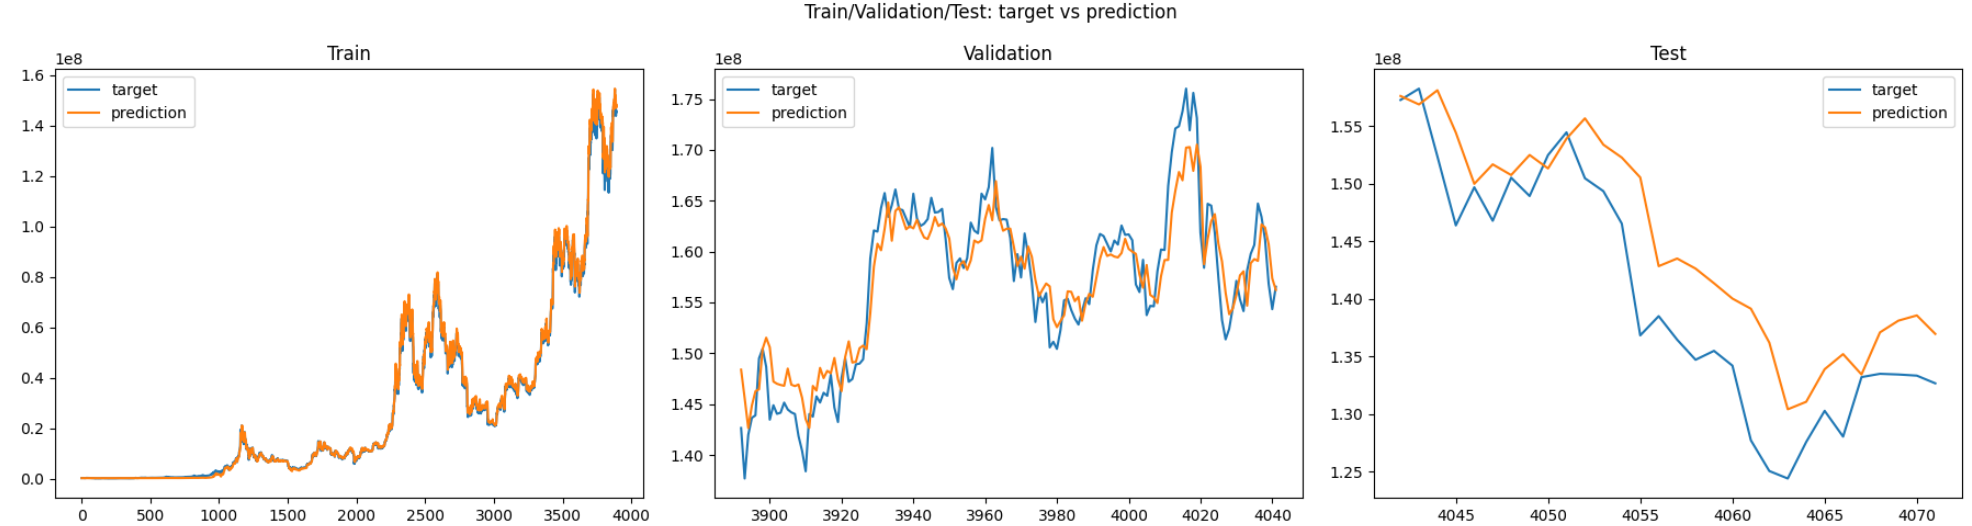

MODEL FILE: /content/btc_krw_lstm_best_regression.pt

[TEST DATA PREDICTION]
 0: Pred:  157,601,061 | Target:  157,256,165 | Loss:      344,896
 1: Pred:  156,867,561 | Target:  158,239,231 | Loss:    1,371,670
 2: Pred:  158,100,147 | Target:  152,359,905 | Loss:    5,740,242
 3: Pred:  154,424,391 | Target:  146,372,509 | Loss:    8,051,882
 4: Pred:  149,977,999 | Target:  149,681,120 | Loss:      296,879
 5: Pred:  151,669,598 | Target:  146,775,246 | Loss:    4,894,352
 6: Pred:  150,741,968 | Target:  150,509,186 | Loss:      232,782
 7: Pred:  152,483,339 | Target:  148,921,728 | Loss:    3,561,611
 8: Pred:  151,313,801 | Target:  152,478,237 | Loss:    1,164,436
 9: Pred:  153,900,757 | Target:  154,446,573 | Loss:      545,816
10: Pred:  155,662,746 | Target:  150,462,379 | Loss:    5,200,367
11: Pred:  153,379,192 | Target:  149,344,368 | Loss:    4,034,824
12: Pred:  152,258,873 | Target:  146,526,642 | Loss:    5,732,231
13: Pred:  150,532,150 | Target:  136,829,596 | Loss

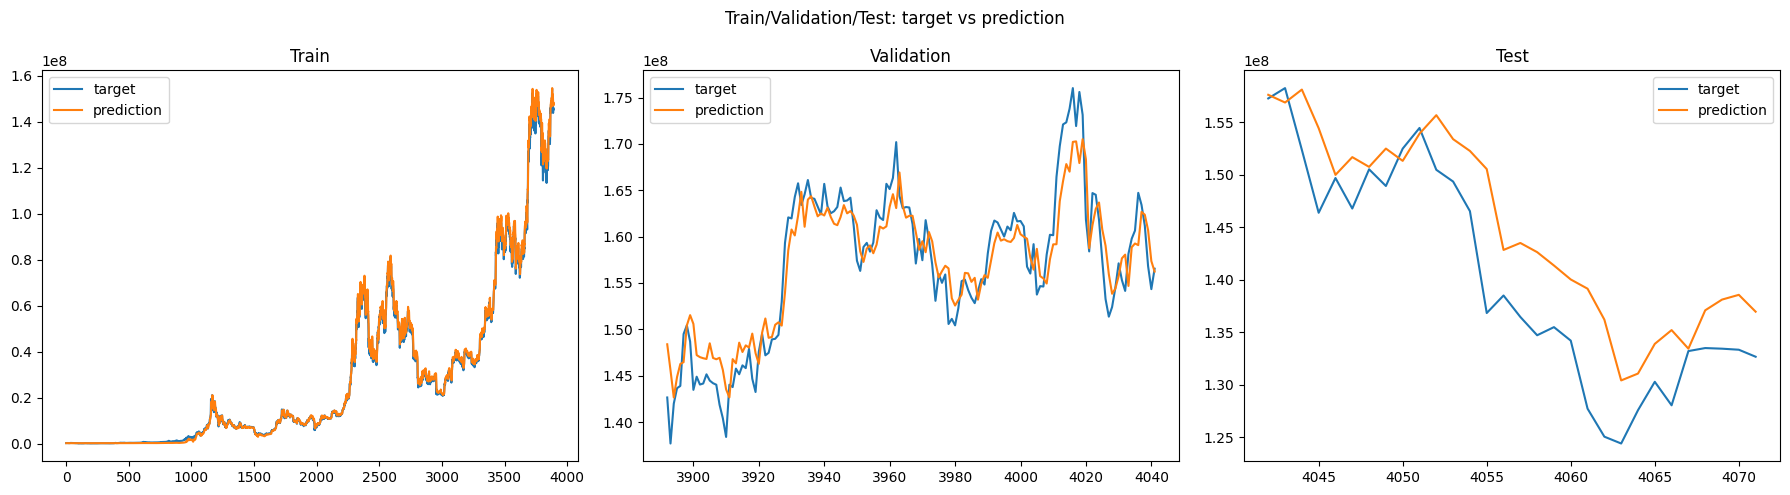

test_mae_krw,▁
test_mae_scaled,▁
test_mape_pct,▁
test_max_ae_krw,▁
test_rmse_krw,▁
test_mae_krw,4889423.05247
test_mae_scaled,0.48894
test_mape_pct,3.59184
test_max_ae_krw,13702554.70276
test_rmse_krw,5913193.66679


In [48]:
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from datetime import datetime

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
CHECKPOINT_PATH = "/content/btc_krw_lstm_best_regression.pt"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30

BEST_LSTM_LAYERS = 2
BEST_HIDDEN_SIZE = 256
BEST_LINEAR_LAYERS = 3
BEST_DROPOUT = 0.1


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    parser.add_argument("--wandb_project", type=str, default="btc_krw_lstm_test_regression")
    parser.add_argument("--wandb_entity", type=str, default=None)
    parser.add_argument("--wandb_name", type=str, default=None)
    parser.add_argument("--wandb_tags", nargs="*", default=["lstm", "regression", "btc_krw", "inference"])
    parser.add_argument("--wandb_mode", type=str, default=None)
    parser.add_argument("--log_plot", action=argparse.BooleanOptionalAction, default=True)

    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=200)
    parser.add_argument("-r", "--learning_rate", type=float, default=0.0005)
    parser.add_argument("-w", "--weight_decay", type=float, default=1e-5)
    parser.add_argument("-v", "--validation_intervals", type=int, default=10)
    parser.add_argument("-p", "--early_stop_patience", type=int, default=30)
    parser.add_argument("-d", "--early_stop_delta", type=float, default=0.000001)
    return parser


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i: i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]['Close'])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class MyLSTM(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=BEST_HIDDEN_SIZE,
            num_layers=BEST_LSTM_LAYERS,
            batch_first=True,
            dropout=BEST_DROPOUT if BEST_LSTM_LAYERS > 1 else 0.0
        )

        layers = []
        for _ in range(max(0, BEST_LINEAR_LAYERS - 1)):
            layers.append(nn.Linear(BEST_HIDDEN_SIZE, BEST_HIDDEN_SIZE))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(BEST_DROPOUT))
        layers.append(nn.Linear(BEST_HIDDEN_SIZE, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


def test(test_model, X_test, y_test):
    test_model.eval()
    y_normalizer = 1.0e7
    print("\n[TEST DATA PREDICTION]")

    rows = []
    abs_errs = []
    pct_errs = []

    with torch.no_grad():
        output_test = test_model(X_test).squeeze(-1)
        y_np = y_test.detach().cpu().numpy()

        for idx, (output, target_scaled) in enumerate(zip(output_test.detach().cpu().numpy(), y_np)):
            pred_krw = float(output) * y_normalizer
            targ_krw = float(target_scaled) * y_normalizer
            abs_err = abs(pred_krw - targ_krw)
            pct_err = abs_err / max(1.0, abs(targ_krw)) * 100.0

            print(f"{idx:2}: Pred: {pred_krw:12,.0f} | Target: {targ_krw:12,.0f} | Loss: {abs_err:12,.0f}")

            rows.append([idx, pred_krw, targ_krw, abs_err, pct_err])
            abs_errs.append(abs_err)
            pct_errs.append(pct_err)

    mae_krw = float(np.mean(abs_errs)) if abs_errs else float("nan")
    rmse_krw = float(np.sqrt(np.mean(np.square(abs_errs)))) if abs_errs else float("nan")
    max_ae_krw = float(np.max(abs_errs)) if abs_errs else float("nan")
    mape_pct = float(np.mean(pct_errs)) if pct_errs else float("nan")

    print("\n[TEST SUMMARY]")
    print(f"MAE (KRW) : {mae_krw:,.2f}")
    print(f"RMSE (KRW): {rmse_krw:,.2f}")
    print(f"MAX AE(KRW): {max_ae_krw:,.2f}")
    print(f"MAPE (%)  : {mape_pct:,.4f}")

    metrics = {
        "test_mae_krw": mae_krw,
        "test_rmse_krw": rmse_krw,
        "test_max_ae_krw": max_ae_krw,
        "test_mape_pct": mape_pct,
        "test_mae_scaled": mae_krw / 1.0e7 if np.isfinite(mae_krw) else float("nan"),
    }
    return metrics, rows


def predict_all(test_model, datasets, title="predict_all"):
    test_model.eval()
    y_normalizer = 1.0e7
    labels = ["Train", "Validation", "Test"]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    current_idx = 0

    for i, (X, y) in enumerate(datasets):
        with torch.no_grad():
            prediction = test_model(X).squeeze().detach().cpu().numpy() * y_normalizer
            target = y.detach().cpu().numpy() * y_normalizer
            X_axis = np.arange(current_idx, current_idx + len(target))
            axs[i].plot(X_axis, target, label='target')
            axs[i].plot(X_axis, prediction, label='prediction')
            axs[i].set_title(labels[i])
            axs[i].legend()
            current_idx += len(target)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    return fig


def init_wandb(args, device):
    use_wandb = bool(args.wandb) and (wandb is not None)
    if not use_wandb:
        return None

    mode = args.wandb_mode
    if mode is None:
        mode = "online"

    run_name = args.wandb_name
    if run_name is None:
        run_name = datetime.now().astimezone().strftime("infer_%m%d_%H%M%S")

    cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "lstm_layers": BEST_LSTM_LAYERS,
        "hidden_size": BEST_HIDDEN_SIZE,
        "linear_layers": BEST_LINEAR_LAYERS,
        "dropout": BEST_DROPOUT,
        "checkpoint_path": CHECKPOINT_PATH,
        "device": str(device),
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "learning_rate": args.learning_rate,
        "weight_decay": args.weight_decay,
    }

    run = wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        tags=args.wandb_tags,
        config=cfg,
        mode=mode
    )
    return run


def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    run = init_wandb(args, device)

    model = MyLSTM(5, 1).to(device)

    if os.path.exists(CHECKPOINT_PATH):
        model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
        print(f"MODEL FILE: {CHECKPOINT_PATH}")
    else:
        raise FileNotFoundError(f"Checkpoint not found: {CHECKPOINT_PATH}")

    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE
    )

    metrics, rows = test(model, X_test.to(device), y_test)

    if run is not None:
        wandb.log(metrics)
        if rows:
            table = wandb.Table(columns=["idx", "pred_krw", "target_krw", "abs_error_krw", "abs_error_pct"], data=rows)
            wandb.log({"test_predictions_table": table})

    model_cpu = model.cpu()
    fig = predict_all(
        model_cpu,
        [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
        title="Train/Validation/Test: target vs prediction"
    )

    if run is not None and bool(args.log_plot):
        wandb.log({"predict_all_plot": wandb.Image(fig)})
        plt.close(fig)

    if run is not None:
        wandb.summary.update(metrics)
        wandb.finish()


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


## 2-4 선정한 분류 모델 결과 제시

In [50]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import argparse
from datetime import datetime

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"
CHECKPOINT_PATH = "/content/btc_krw_lstm_best_classification.pt"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30

BEST_LSTM_LAYERS = 3
BEST_HIDDEN_SIZE = 256
BEST_LINEAR_LAYERS = 1
BEST_DROPOUT = 0.2
BEST_WEIGHT_DECAY = 1e-6


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    parser.add_argument("--wandb_project", type=str, default="btc_krw_lstm_test_classification")
    parser.add_argument("--wandb_entity", type=str, default=None)
    parser.add_argument("--wandb_name", type=str, default=None)
    parser.add_argument("--wandb_tags", nargs="*", default=["lstm", "classification", "btc_krw", "inference"])
    parser.add_argument("--wandb_mode", type=str, default=None)  # online / offline / disabled

    parser.add_argument("-b", "--batch_size", type=int, default=64)
    parser.add_argument("-e", "--epochs", type=int, default=100)
    parser.add_argument("-r", "--learning_rate", type=float, default=1e-4)
    return parser


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})
    cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i: i + sequence_size].values)
        target = 1 if df_numeric.iloc[i + sequence_size]['Close'] >= df_numeric.iloc[i + sequence_size - 1]['Close'] else 0
        y_list.append(target)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)
    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=BEST_HIDDEN_SIZE,
            num_layers=BEST_LSTM_LAYERS,
            batch_first=True,
            dropout=BEST_DROPOUT if BEST_LSTM_LAYERS > 1 else 0.0
        )

        layers = []
        for _ in range(max(0, BEST_LINEAR_LAYERS - 1)):
            layers.append(nn.Linear(BEST_HIDDEN_SIZE, BEST_HIDDEN_SIZE))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(BEST_DROPOUT))
        layers.append(nn.Linear(BEST_HIDDEN_SIZE, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)



def init_wandb(args):
    use_wandb = bool(args.wandb) and (wandb is not None)
    if not use_wandb:
        return None

    mode = args.wandb_mode if args.wandb_mode is not None else "online"
    run_name = args.wandb_name if args.wandb_name is not None else datetime.now().astimezone().strftime("infer_%m%d_%H%M%S")

    cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "lstm_layers": BEST_LSTM_LAYERS,
        "hidden_size": BEST_HIDDEN_SIZE,
        "linear_layers": BEST_LINEAR_LAYERS,
        "dropout": BEST_DROPOUT,
        "weight_decay": BEST_WEIGHT_DECAY,
        "checkpoint_path": CHECKPOINT_PATH,
        "batch_size": args.batch_size,
        "learning_rate": args.learning_rate,
        "epochs": args.epochs,
    }

    run = wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        tags=args.wandb_tags,
        config=cfg,
        mode=mode
    )
    return run


def test(test_model, X_test, y_test):
    test_model.eval()

    with torch.no_grad():
        output_test = test_model(X_test)
        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects = torch.sum(torch.eq(predicted_test, y_test)).item()
        test_accuracy = 100.0 * num_corrects / len(y_test)

    print("[TEST DATA]")
    print(f"TEST RESULTS: {test_accuracy:6.3f}%")
    print("\n[SAMPLE COMPARISON (Pred <--> Target)]")
    for idx, (pred, target) in enumerate(zip(predicted_test, y_test)):
        print(f"{idx:2}: {pred.item()} <--> {target.item()}")

    return float(test_accuracy), predicted_test.detach().cpu().numpy(), y_test.detach().cpu().numpy()


def main(args):
    run = init_wandb(args)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(n_input=5, n_output=2).to(device)

    if os.path.exists(CHECKPOINT_PATH):
        model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
        print(f"MODEL FILE: {CHECKPOINT_PATH}")
    else:
        raise FileNotFoundError(f"Checkpoint not found: {CHECKPOINT_PATH}")

    _, _, X_test, _, _, y_test = get_btc_krw_data(
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE
    )

    test_acc, preds, targets = test(model, X_test.to(device), y_test.to(device))

    if run is not None:
        wandb.log({"test_acc_percent": test_acc})
        table = wandb.Table(columns=["idx", "pred", "target", "is_correct"])
        for i in range(len(preds)):
            table.add_data(int(i), int(preds[i]), int(targets[i]), int(preds[i] == targets[i]))
        wandb.log({"test_predictions_table": table})
        wandb.summary.update({"test_acc_percent": test_acc})
        wandb.finish()


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


MODEL FILE: /content/btc_krw_lstm_best_classification.pt
[TEST DATA]
TEST RESULTS: 60.000%

[SAMPLE COMPARISON (Pred <--> Target)]
 0: 1 <--> 1
 1: 1 <--> 1
 2: 1 <--> 0
 3: 0 <--> 0
 4: 1 <--> 1
 5: 1 <--> 0
 6: 1 <--> 1
 7: 1 <--> 0
 8: 1 <--> 1
 9: 0 <--> 1
10: 0 <--> 0
11: 0 <--> 0
12: 0 <--> 0
13: 0 <--> 0
14: 1 <--> 1
15: 1 <--> 0
16: 1 <--> 0
17: 1 <--> 1
18: 1 <--> 0
19: 1 <--> 0
20: 0 <--> 0
21: 0 <--> 0
22: 0 <--> 1
23: 0 <--> 1
24: 0 <--> 0
25: 0 <--> 1
26: 0 <--> 1
27: 0 <--> 0
28: 0 <--> 0
29: 0 <--> 0


test_acc_percent,▁
test_acc_percent,60


## 3-1 next-open 추가한 회귀 모델과 비교하기

next-open 없는 회귀 모델
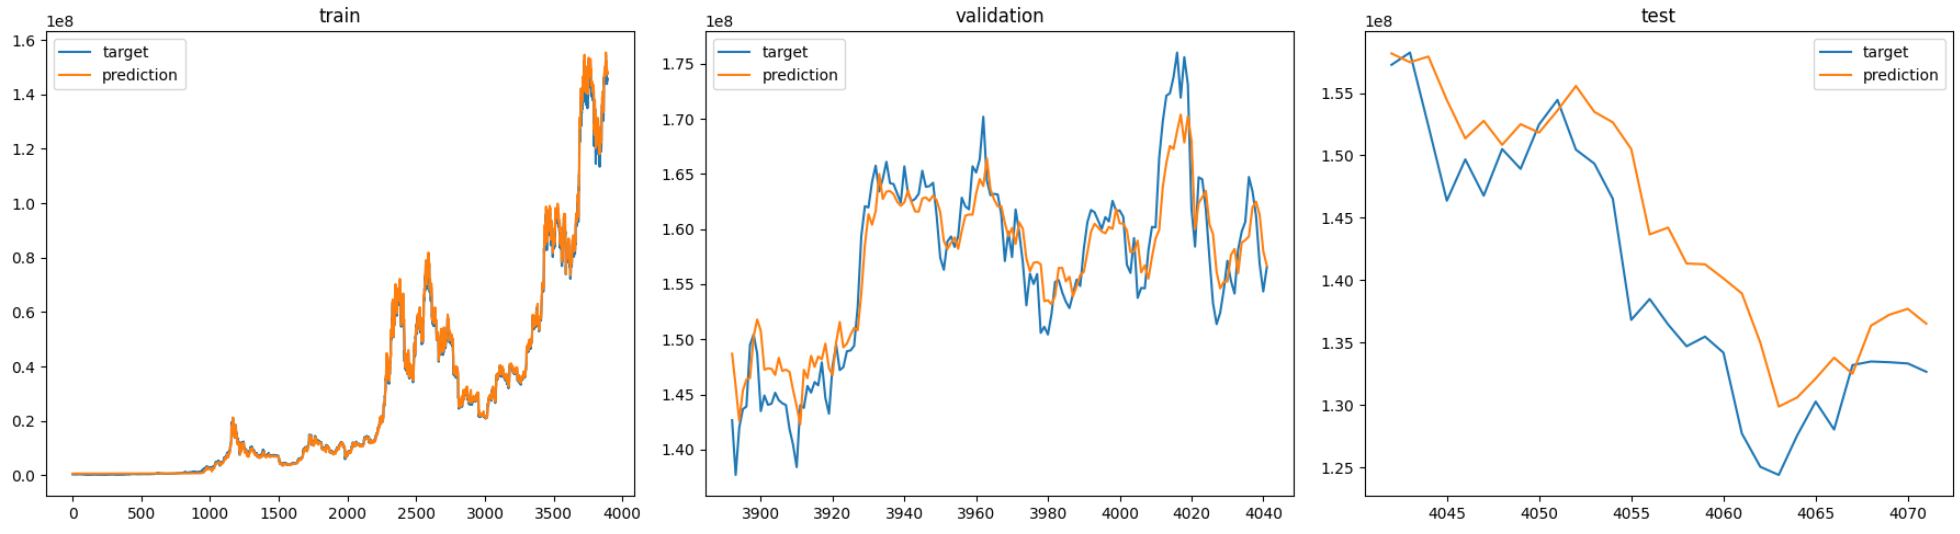
next-open 추가한 회귀 모델
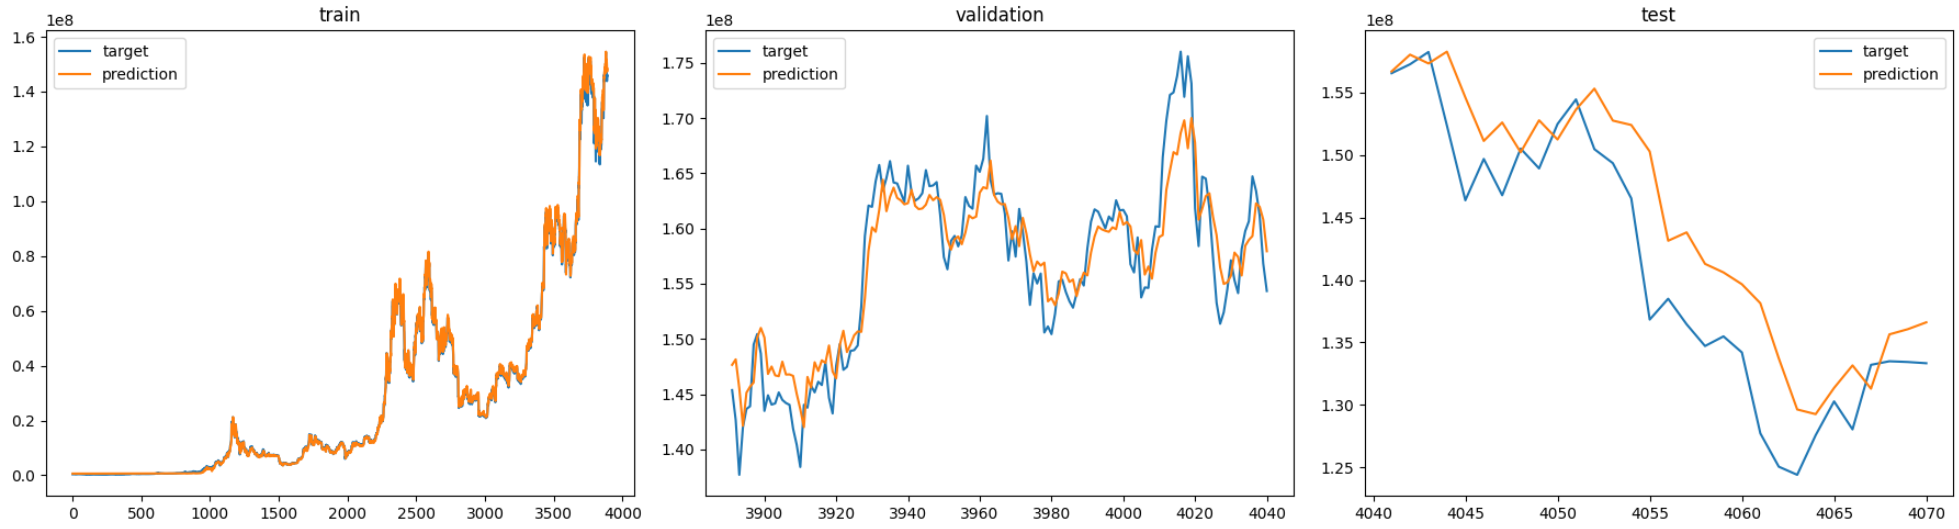

------
수치 비교
[BASE] Metrics: {'best_val_loss': 0.096, 'test_abs_error_mae_krw': 4721275.0, 'test_rmse_krw': 5702293.0, 'n_input_features': 5}

[WITH] Metrics: {'best_val_loss': 0.098, 'test_abs_error_mae_krw': 4276133.0, 'test_rmse_krw': 5320627.5, 'n_input_features': 6}

### 분석
기존 입력 값과 유사한 성격의 데이터가 추가되었고 그 차이는 그렇게 큰 차이를 주지 못한 것 같다.

[BASE] Epoch   1 | train_loss=5.755644 | val_loss=1.340750
[BASE] Epoch  20 | train_loss=0.094006 | val_loss=0.431964
[BASE] Epoch  40 | train_loss=0.068521 | val_loss=0.213609
[BASE] Epoch  60 | train_loss=0.066477 | val_loss=0.277717
[BASE] Epoch  80 | train_loss=0.066090 | val_loss=0.507643
[BASE] Epoch 100 | train_loss=0.065500 | val_loss=0.109168
[BASE] Epoch 120 | train_loss=0.072853 | val_loss=1.150377
[BASE] Epoch 140 | train_loss=0.061760 | val_loss=0.281361
[BASE] Epoch 160 | train_loss=0.071531 | val_loss=0.123556
[BASE] Epoch 180 | train_loss=0.068233 | val_loss=0.112820
[BASE] Epoch 200 | train_loss=0.051854 | val_loss=0.108733
[BASE] Saved checkpoint: /content/btc_krw_p3_reg_baseline.pt
[BASE] Metrics: {'best_val_loss': 0.09642838438351949, 'test_abs_error_mae_krw': 4721275.0, 'test_rmse_krw': 5702293.0, 'n_input_features': 5}


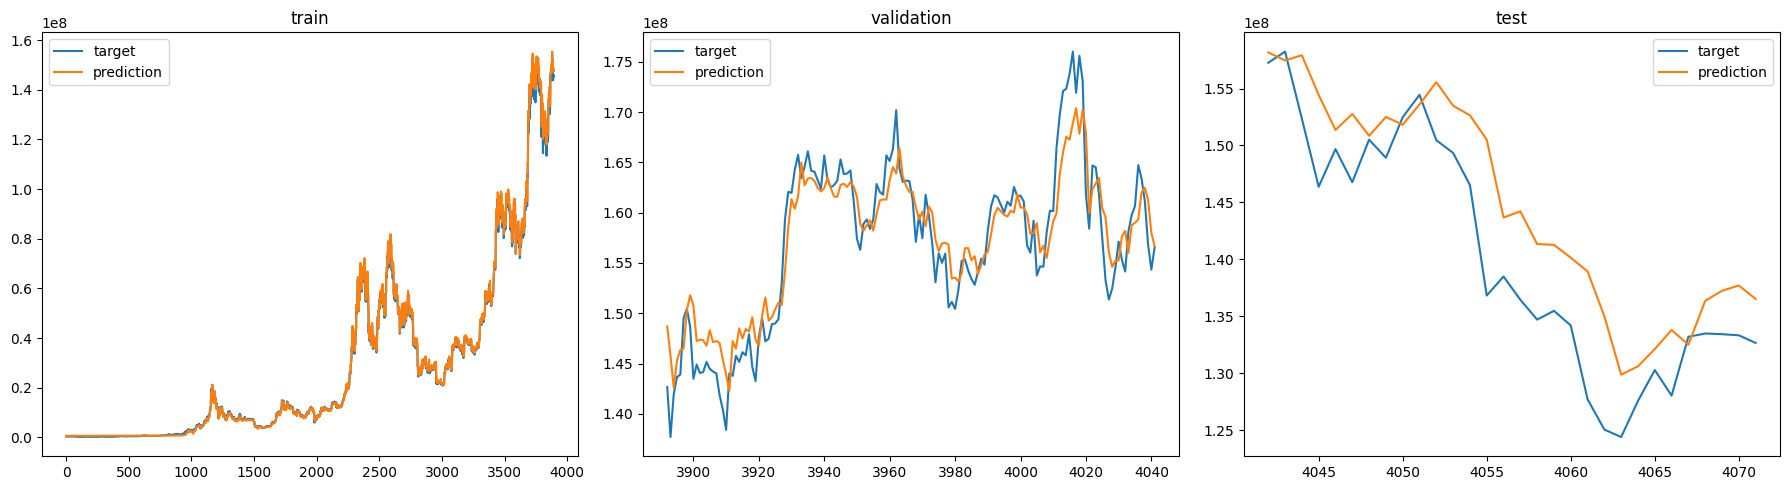

best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
n_input_features,▁
test_abs_error_mae_krw,▁
test_rmse_krw,▁
train_loss,█▅▅▄▄▃▂▃▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▃▂▂▁▁▂▂▁▂▁▁▂▁▂▁▂▁
val_loss,▂▂█▅▃▆▁▁▂▁▁▁█▂▃▃▂▁▂▇▁▂█▁▃▁▂▁▃▁▁▂▁▁▃▃▄▆▁▁
best_val_loss,0.09643
epoch,200
n_input_features,5
test_abs_error_mae_krw,4721275.0


[WITH] Epoch   1 | train_loss=5.801971 | val_loss=0.766764
[WITH] Epoch  20 | train_loss=0.084889 | val_loss=0.126875
[WITH] Epoch  40 | train_loss=0.069386 | val_loss=0.171950
[WITH] Epoch  60 | train_loss=0.078727 | val_loss=0.142313
[WITH] Epoch  80 | train_loss=0.067680 | val_loss=0.253643
[WITH] Epoch 100 | train_loss=0.061875 | val_loss=0.299407
[WITH] Epoch 120 | train_loss=0.091173 | val_loss=0.124541
[WITH] Epoch 140 | train_loss=0.065557 | val_loss=0.271168
[WITH] Epoch 160 | train_loss=0.060252 | val_loss=0.140057
[WITH] Epoch 180 | train_loss=0.070029 | val_loss=0.193800
[WITH] Epoch 200 | train_loss=0.064673 | val_loss=0.142715
[WITH] Saved checkpoint: /content/btc_krw_p3_reg_with_next_open.pt
[WITH] Metrics: {'best_val_loss': 0.09897056718667348, 'test_abs_error_mae_krw': 4276133.0, 'test_rmse_krw': 5320627.5, 'n_input_features': 6}


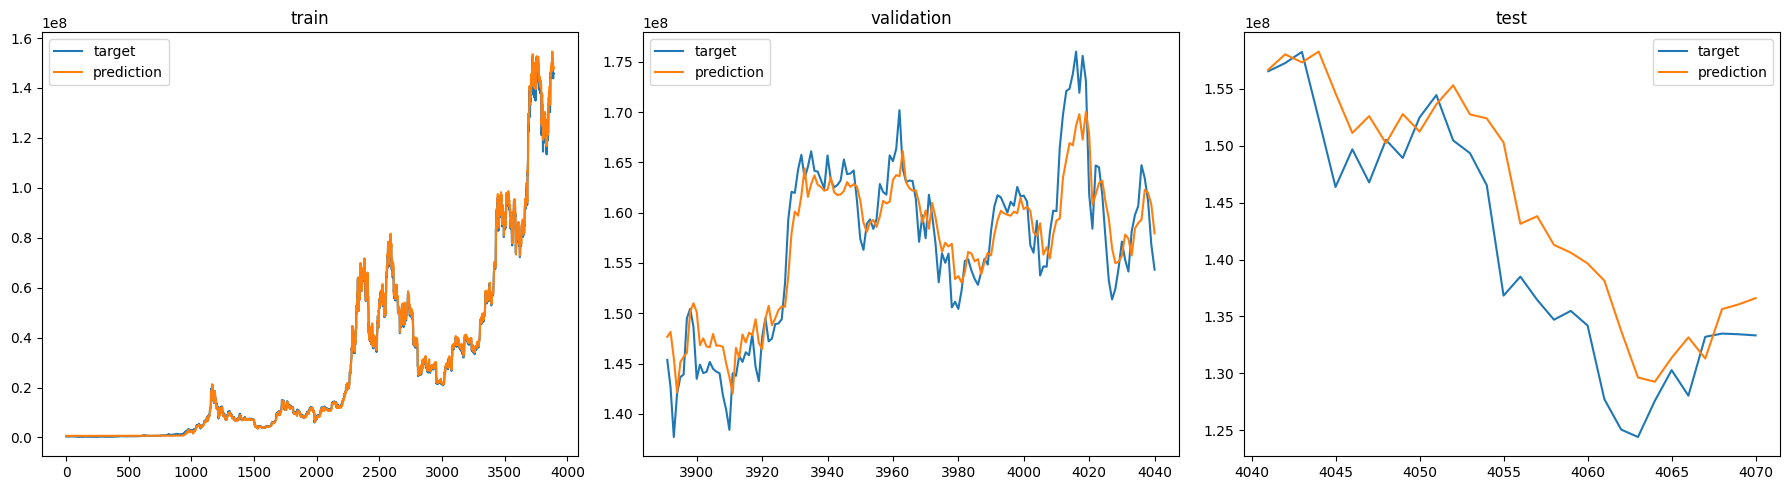

best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
n_input_features,▁
test_abs_error_mae_krw,▁
test_rmse_krw,▁
train_loss,█▆▅▆▅▄▃▅▃▃▃▃▇▄▂▄▃▅▂▂▃▂▃▂▃▃▃▂▂▃▃▂▃▂▁▁▁▂▂▁
val_loss,▇▅█▂▁▂▁▂▂▂▁▂▁▁▁▂▁▃▃▁▁▃▂▁▁▂▆▁▁▁▁▆▃▁▁▂▂▂▂▁
best_val_loss,0.09897
epoch,200
n_input_features,6
test_abs_error_mae_krw,4276133.0


In [62]:
import os
import random
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30
IS_REGRESSION = True

BEST_LSTM_LAYERS = 2
BEST_HIDDEN_SIZE = 256
BEST_LINEAR_LAYERS = 3
BEST_DROPOUT = 0.1
BEST_WEIGHT_DECAY = 1e-5

BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 5e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_parser():
    p = argparse.ArgumentParser()
    p.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    p.add_argument("--wandb_project", type=str, default="btc_krw_problem3_regression_next_open")
    p.add_argument("--wandb_entity", type=str, default=None)
    p.add_argument("--wandb_mode", type=str, default=None)
    p.add_argument("--wandb_tags", nargs="*", default=["lstm", "regression", "problem3", "next_open"])
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--epochs", type=int, default=EPOCHS)
    p.add_argument("--batch_size", type=int, default=BATCH_SIZE)
    p.add_argument("--lr", type=float, default=LEARNING_RATE)
    p.add_argument("--print_every", type=int, default=20)
    return p


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(add_next_open: bool, sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={"Price": "Date"})

    base_cols = ["Close", "High", "Low", "Open", "Volume"]
    for col in base_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

    if add_next_open:
        df["Next_Open"] = df["Open"].shift(-1)
        cols = base_cols + ["Next_Open"]
    else:
        cols = base_cols

    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]["Close"])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (
        X[:train_end],
        X[train_end:-test_size],
        X[-test_size:],
        y[:train_end],
        y[train_end:-test_size],
        y[-test_size:],
    )


class MyLSTM(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=BEST_HIDDEN_SIZE,
            num_layers=BEST_LSTM_LAYERS,
            batch_first=True,
            dropout=BEST_DROPOUT if BEST_LSTM_LAYERS > 1 else 0.0,
        )
        layers = []
        for _ in range(max(0, BEST_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(BEST_HIDDEN_SIZE, BEST_HIDDEN_SIZE), nn.ReLU(), nn.Dropout(BEST_DROPOUT)]
        layers.append(nn.Linear(BEST_HIDDEN_SIZE, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


def predict_all(test_model, add_next_open: bool):
    y_normalizer = 1.0e7

    X_train, X_validation, X_test, y_train, y_validation, y_test = get_btc_krw_data(
        add_next_open=add_next_open,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE,
    )

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [train_dataset, validation_dataset, test_dataset]
    dataset_labels = ["train", "validation", "test"]

    num = 0
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    test_model.eval()
    with torch.no_grad():
        for i in range(3):
            X_idx = []
            TARGET_Y = []
            PREDICTION_Y = []
            for data in dataset_list[i]:
                inp, tgt = data
                pred = test_model(inp.unsqueeze(0)).squeeze(-1).squeeze(-1)

                X_idx.append(num)
                TARGET_Y.append(float(tgt.item() * y_normalizer))
                PREDICTION_Y.append(float(pred.item() * y_normalizer))
                num += 1

            axs[i].plot(X_idx, TARGET_Y, label="target")
            axs[i].plot(X_idx, PREDICTION_Y, label="prediction")
            axs[i].set_title(dataset_labels[i])
            axs[i].legend()

    plt.tight_layout()
    return fig


def evaluate_test_mae(model, X_test, y_test):
    model.eval()
    y_normalizer = 1.0e7
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).detach().cpu().numpy() * y_normalizer
        tgt = y_test.detach().cpu().numpy() * y_normalizer
    abs_err = np.abs(pred - tgt)
    return float(np.mean(abs_err)), float(np.sqrt(np.mean((pred - tgt) ** 2)))


def run_one_experiment(args, add_next_open: bool):
    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        add_next_open=add_next_open,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE,
    )

    n_input = X_train.shape[-1]
    model = MyLSTM(n_input=n_input, n_output=1).to(DEVICE)

    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=BEST_WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    train_losses = []
    val_losses = []

    for epoch in range(args.epochs):
        model.train()
        t_loss = 0.0
        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            pred = model(bx).squeeze(-1)
            loss = loss_fn(pred, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        t_loss /= max(1, len(train_loader))

        model.eval()
        v_loss = 0.0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_pred = model(vx).squeeze(-1)
                v_loss += loss_fn(v_pred, vy).item()
        v_loss /= max(1, len(val_loader))

        train_losses.append(float(t_loss))
        val_losses.append(float(v_loss))

        if v_loss < best_val:
            best_val = v_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if (epoch == 0) or ((epoch + 1) % args.print_every == 0):
            print(
                f"[{'WITH' if add_next_open else 'BASE'}] Epoch {epoch+1:3d} | train_loss={t_loss:.6f} | val_loss={v_loss:.6f}"
            )

    model.load_state_dict(best_state)

    X_test_dev = X_test.to(DEVICE)
    y_test_dev = y_test.to(DEVICE)
    test_mae_krw, test_rmse_krw = evaluate_test_mae(model, X_test_dev, y_test_dev)

    model_cpu = model.cpu()

    fig_predict_all = predict_all(
        test_model=model_cpu,
        add_next_open=add_next_open,
    )

    metrics = {
        "best_val_loss": float(best_val),
        "test_abs_error_mae_krw": float(test_mae_krw),
        "test_rmse_krw": float(test_rmse_krw),
        "n_input_features": int(n_input),
    }

    return model_cpu, fig_predict_all, metrics, train_losses, val_losses


def init_wandb_run(args, run_name, config):
    if not (bool(args.wandb) and wandb is not None):
        return None
    mode = args.wandb_mode if args.wandb_mode is not None else "online"
    return wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        tags=args.wandb_tags,
        config=config,
        mode=mode,
    )


def main(args):
    seed_everything(args.seed)

    common_cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "is_regression": True,
        "lstm_layers": BEST_LSTM_LAYERS,
        "hidden_size": BEST_HIDDEN_SIZE,
        "linear_layers": BEST_LINEAR_LAYERS,
        "dropout": BEST_DROPOUT,
        "weight_decay": BEST_WEIGHT_DECAY,
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "learning_rate": args.lr,
        "device": str(DEVICE),
    }

    for add_next_open in [False, True]:
        run_time = datetime.now().astimezone().strftime("%m%d_%H%M%S")
        tag = "with_next_open" if add_next_open else "baseline"
        run_name = f"p3_reg_{tag}_{run_time}"

        run_cfg = dict(common_cfg)
        run_cfg["add_next_open"] = add_next_open

        run = init_wandb_run(args, run_name, run_cfg)

        model_cpu, fig, metrics, train_losses, val_losses = run_one_experiment(args, add_next_open)

        ckpt_path = f"/content/btc_krw_p3_reg_{tag}.pt"
        torch.save(model_cpu.state_dict(), ckpt_path)
        print(f"[{'WITH' if add_next_open else 'BASE'}] Saved checkpoint: {ckpt_path}")
        print(f"[{'WITH' if add_next_open else 'BASE'}] Metrics: {metrics}")

        fig_path = f"/content/predict_all_{tag}.png"
        fig.savefig(fig_path, dpi=150, bbox_inches="tight")
        plt.show()

        if run is not None:
            for i, (tl, vl) in enumerate(zip(train_losses, val_losses), start=1):
                wandb.log({"train_loss": tl, "val_loss": vl, "epoch": i})
            wandb.log(metrics)
            wandb.log({f"predict_all_{tag}": wandb.Image(fig)})
            wandb.summary.update(metrics)
            wandb.finish()

        plt.close(fig)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


## 3-2 next-open을 추가한 분류 모델과 비교하기
기본

* best_val_acc: 0.573

* best_val_loss: 0.679

* test_acc: 0.533

* test_loss: 0.676



추가

* best_val_acc: 0.573

* best_val_loss: 0.690

* test_acc: 0.566

* test_loss: 0.690

### 분석
next-open은 새로운 정보이지만 기존 있던 정보와 유사한 성격의 정보이기 때문에 드라마틱한 차이를 주지 못한 것으로 보인다. 그 때문에 분류 기준에도 별다른 차이를 주지 않아 비슷하게 나온 것 같다.

In [52]:
import os
import random
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30
IS_REGRESSION = False

BEST_LSTM_LAYERS = 3
BEST_HIDDEN_SIZE = 256
BEST_LINEAR_LAYERS = 1
BEST_DROPOUT = 0.2
BEST_WEIGHT_DECAY = 1e-6

BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_parser():
    p = argparse.ArgumentParser()
    p.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    p.add_argument("--wandb_project", type=str, default="btc_krw_problem3_classification_next_open")
    p.add_argument("--wandb_entity", type=str, default=None)
    p.add_argument("--wandb_mode", type=str, default=None)
    p.add_argument("--wandb_tags", nargs="*", default=["lstm", "classification", "problem3", "next_open"])
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--epochs", type=int, default=EPOCHS)
    p.add_argument("--batch_size", type=int, default=BATCH_SIZE)
    p.add_argument("--lr", type=float, default=LEARNING_RATE)
    p.add_argument("--print_every", type=int, default=10)
    return p


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(add_next_open: bool, sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})

    base_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in base_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

    if add_next_open:
        df["Next_Open"] = df["Open"].shift(-1)
        cols = base_cols + ["Next_Open"]
    else:
        cols = base_cols

    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i:i + sequence_size].values)
        cur_close = df_numeric.iloc[i + sequence_size - 1]['Close']
        next_close = df_numeric.iloc[i + sequence_size]['Close']
        y_list.append(1 if next_close >= cur_close else 0)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class MyLSTMCls(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=BEST_HIDDEN_SIZE,
            num_layers=BEST_LSTM_LAYERS,
            batch_first=True,
            dropout=BEST_DROPOUT if BEST_LSTM_LAYERS > 1 else 0.0
        )
        layers = []
        for _ in range(max(0, BEST_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(BEST_HIDDEN_SIZE, BEST_HIDDEN_SIZE), nn.ReLU(), nn.Dropout(BEST_DROPOUT)]
        layers.append(nn.Linear(BEST_HIDDEN_SIZE, n_output))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


def evaluate_cls(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)
        acc = (pred == y).float().mean().item()
        loss = nn.CrossEntropyLoss()(logits, y).item()
    return float(acc), float(loss)


def run_one_experiment(args, add_next_open: bool):
    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        add_next_open=add_next_open,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE
    )

    n_input = X_train.shape[-1]
    model = MyLSTMCls(n_input=n_input, n_output=2).to(DEVICE)

    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=BEST_WEIGHT_DECAY)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float("inf")
    best_val_acc = -1.0
    best_state = None

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(args.epochs):
        model.train()
        t_loss = 0.0
        t_corr = 0
        n = 0

        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            logits = model(bx)
            loss = loss_fn(logits, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            t_corr += (torch.argmax(logits, dim=1) == by).sum().item()
            n += by.size(0)

        t_loss /= max(1, len(train_loader))
        t_acc = t_corr / max(1, n)

        model.eval()
        v_loss = 0.0
        v_corr = 0
        vn = 0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_logits = model(vx)
                v_loss += loss_fn(v_logits, vy).item()
                v_corr += (torch.argmax(v_logits, dim=1) == vy).sum().item()
                vn += vy.size(0)
        v_loss /= max(1, len(val_loader))
        v_acc = v_corr / max(1, vn)

        train_losses.append(float(t_loss))
        val_losses.append(float(v_loss))
        train_accs.append(float(t_acc))
        val_accs.append(float(v_acc))

        improved = False
        if v_acc > best_val_acc + 1e-12:
            improved = True
        elif abs(v_acc - best_val_acc) <= 1e-12 and v_loss < best_val_loss:
            improved = True

        if improved:
            best_val_acc = float(v_acc)
            best_val_loss = float(v_loss)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if (epoch == 0) or ((epoch + 1) % args.print_every == 0):
            print(f"[{'WITH' if add_next_open else 'BASE'}] Epoch {epoch+1:3d} | "
                  f"train_acc={t_acc:.4f} train_loss={t_loss:.6f} | val_acc={v_acc:.4f} val_loss={v_loss:.6f}")

    model.load_state_dict(best_state)
    test_acc, test_loss = evaluate_cls(model, X_test.to(DEVICE), y_test.to(DEVICE))

    metrics = {
        "best_val_acc": float(best_val_acc),
        "best_val_loss": float(best_val_loss),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
        "n_input_features": int(n_input),
    }

    return model.cpu(), metrics, train_losses, val_losses, train_accs, val_accs


def init_wandb_run(args, run_name, config):
    if not (bool(args.wandb) and wandb is not None):
        return None
    mode = args.wandb_mode if args.wandb_mode is not None else "online"
    return wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        tags=args.wandb_tags,
        config=config,
        mode=mode
    )


def main(args):
    seed_everything(args.seed)

    common_cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "is_regression": False,
        "lstm_layers": BEST_LSTM_LAYERS,
        "hidden_size": BEST_HIDDEN_SIZE,
        "linear_layers": BEST_LINEAR_LAYERS,
        "dropout": BEST_DROPOUT,
        "weight_decay": BEST_WEIGHT_DECAY,
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "learning_rate": args.lr,
        "device": str(DEVICE),
    }

    for add_next_open in [False, True]:
        run_time = datetime.now().astimezone().strftime("%m%d_%H%M%S")
        tag = "with_next_open" if add_next_open else "baseline"
        run_name = f"p3_cls_{tag}_{run_time}"

        run_cfg = dict(common_cfg)
        run_cfg["add_next_open"] = add_next_open

        run = init_wandb_run(args, run_name, run_cfg)

        model_cpu, metrics, train_losses, val_losses, train_accs, val_accs = run_one_experiment(args, add_next_open)

        ckpt_path = f"/content/btc_krw_p3_cls_{tag}.pt"
        torch.save(model_cpu.state_dict(), ckpt_path)
        print(f"[{'WITH' if add_next_open else 'BASE'}] Saved checkpoint: {ckpt_path}")
        print(f"[{'WITH' if add_next_open else 'BASE'}] Metrics: {metrics}")

        if run is not None:
            for i in range(args.epochs):
                wandb.log({
                    "epoch": i + 1,
                    "train_loss": train_losses[i],
                    "val_loss": val_losses[i],
                    "train_acc": train_accs[i],
                    "val_acc": val_accs[i],
                })
            wandb.log(metrics)
            wandb.summary.update(metrics)
            wandb.finish()


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


[BASE] Epoch   1 | train_acc=0.5290 train_loss=0.691878 | val_acc=0.5000 val_loss=0.691754
[BASE] Epoch  10 | train_acc=0.5270 train_loss=0.691119 | val_acc=0.5000 val_loss=0.691675
[BASE] Epoch  20 | train_acc=0.5280 train_loss=0.691011 | val_acc=0.5000 val_loss=0.691877
[BASE] Epoch  30 | train_acc=0.5270 train_loss=0.691063 | val_acc=0.5000 val_loss=0.691933
[BASE] Epoch  40 | train_acc=0.5254 train_loss=0.691257 | val_acc=0.5000 val_loss=0.692040
[BASE] Epoch  50 | train_acc=0.5288 train_loss=0.690897 | val_acc=0.5000 val_loss=0.691800
[BASE] Epoch  60 | train_acc=0.5285 train_loss=0.690842 | val_acc=0.5000 val_loss=0.691853
[BASE] Epoch  70 | train_acc=0.5313 train_loss=0.690861 | val_acc=0.5000 val_loss=0.691694
[BASE] Epoch  80 | train_acc=0.5308 train_loss=0.690843 | val_acc=0.5067 val_loss=0.690993
[BASE] Epoch  90 | train_acc=0.5337 train_loss=0.690824 | val_acc=0.5467 val_loss=0.688368
[BASE] Epoch 100 | train_acc=0.5319 train_loss=0.690191 | val_acc=0.5200 val_loss=0.681820

best_val_acc,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
n_input_features,▁
test_acc,▁
test_loss,▁
train_acc,▂▁▁▅▄▃▄▅▂▆▃▄▄▄▃▄▅▄▄▆▅▆▄▄▅▄▆▅▆▅▄▆▅▆▄█▄▇█▆
train_loss,█▆▅▅▅▆▄▄▄▅▄▄▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▃▄▃▃▃▂▁
val_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▂▂▃██▄
val_loss,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▄█▃▃▁
best_val_acc,0.57333


[WITH] Epoch   1 | train_acc=0.5199 train_loss=0.692454 | val_acc=0.5067 val_loss=0.691211
[WITH] Epoch  10 | train_acc=0.5245 train_loss=0.691067 | val_acc=0.5067 val_loss=0.690693
[WITH] Epoch  20 | train_acc=0.5271 train_loss=0.691013 | val_acc=0.5067 val_loss=0.690769
[WITH] Epoch  30 | train_acc=0.5323 train_loss=0.690967 | val_acc=0.5067 val_loss=0.691167
[WITH] Epoch  40 | train_acc=0.5271 train_loss=0.691027 | val_acc=0.5067 val_loss=0.691669
[WITH] Epoch  50 | train_acc=0.5281 train_loss=0.690949 | val_acc=0.5067 val_loss=0.691321
[WITH] Epoch  60 | train_acc=0.5287 train_loss=0.690937 | val_acc=0.5067 val_loss=0.691486
[WITH] Epoch  70 | train_acc=0.5294 train_loss=0.690866 | val_acc=0.5067 val_loss=0.691140
[WITH] Epoch  80 | train_acc=0.5279 train_loss=0.691015 | val_acc=0.5000 val_loss=0.691287
[WITH] Epoch  90 | train_acc=0.5294 train_loss=0.690850 | val_acc=0.5733 val_loss=0.690124
[WITH] Epoch 100 | train_acc=0.5330 train_loss=0.691009 | val_acc=0.5467 val_loss=0.684853

best_val_acc,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
n_input_features,▁
test_acc,▁
test_loss,▁
train_acc,▁▅▄▄▅▄▃▄▄▄▅▅▅▅▆▅▅▆▅▅▅▆▅▃▄▆▅▆▆▄▅▅▅▇█▇▆▆█▇
train_loss,██▆▆▇▆▅▅▅▇▄▃▄▅▄▄▃▅▅▄▄▄▄▅▄▃▆▃▃▃▄▄▅▃▄▂▁▂▁▄
val_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▁▅▅▇█▆▇
val_loss,▇▆█▆▅▇▆▇▇▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▆▇▆▆▇▇▆▆▅▅▄▂▃▁
best_val_acc,0.57333


## 3-3 self-attention 활용해 회귀 모델 비교하기

### 그래프
LSTM
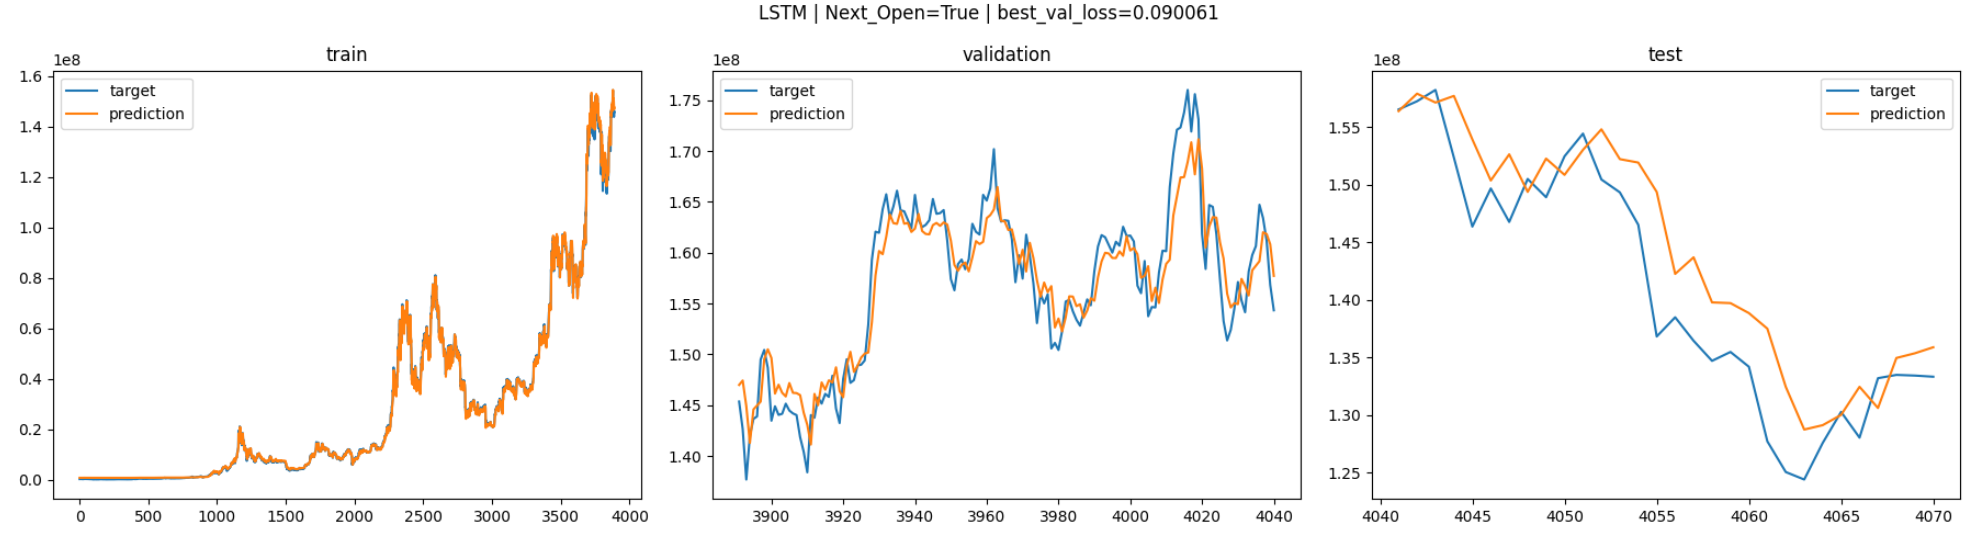
Self-Attention
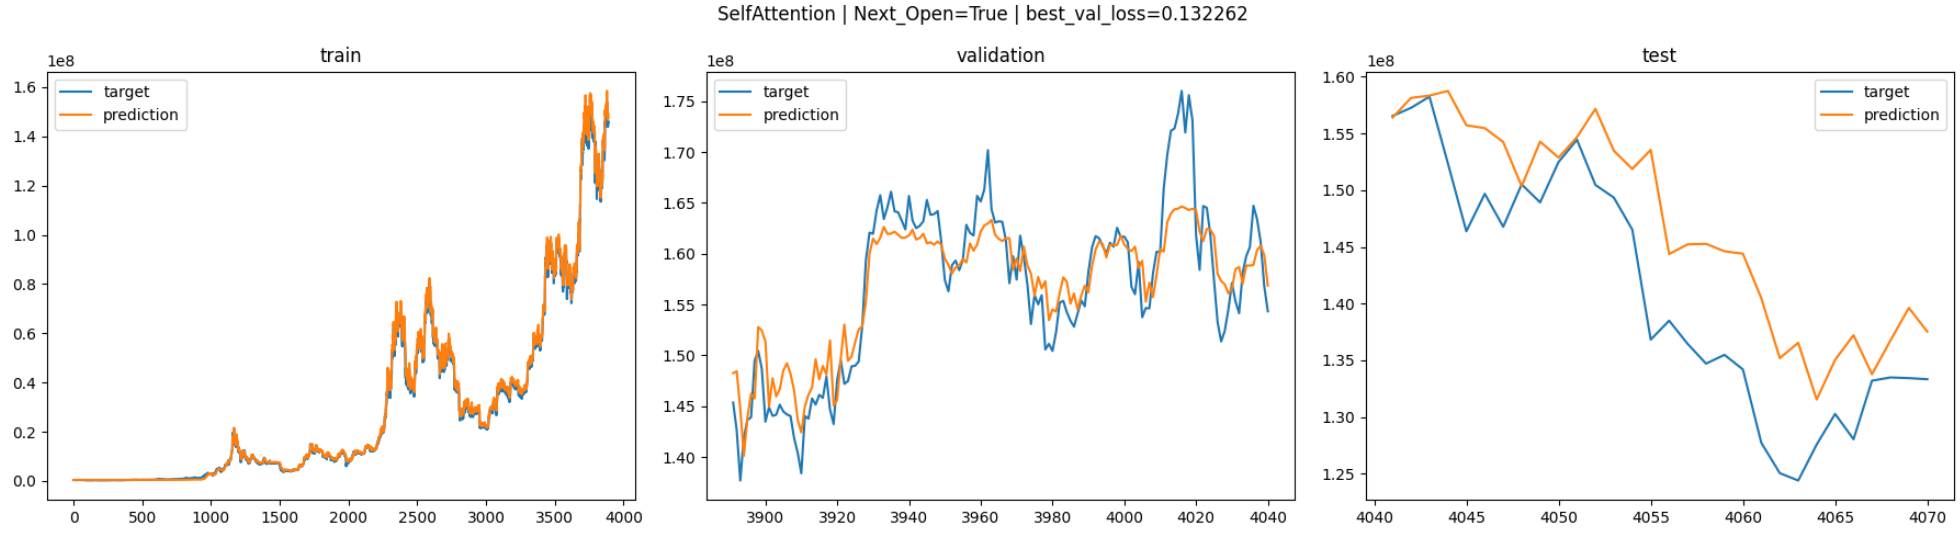
### 성능비교
- LSTM          | best_val_loss=0.090061 | test_mae_krw=3846552.250 | test_rmse_krw=4818339.500
- SelfAttention | best_val_loss=0.132262 | test_mae_krw=6026527.000 | test_rmse_krw=7369536.000

### 분석
이번 문제는 최근 21일 안에서 바로 직전 흐름을 잘 이어서 보는 게 중요해서 그런 흐름을 차곡차곡 쌓아 보는 LSTM이 더 잘 맞았던 것 같다.
반면 self-attention은 윈도우 안의 모든 날을 서로 비교하느라 복잡해질 수 있고, 데이터/구간이 짧을 땐 그 장점이 크게 나오지 않아 성능이 낮게 나온 것 같다.

[LSTM] Epoch    1 | train_loss=21.531044 | val_loss=248.963943 | best=248.963943 | wait=0/80 | lr=2.50e-06
[LSTM] Epoch   20 | train_loss=0.112594 | val_loss=0.788781 | best=0.546249 | wait=2/80 | lr=5.00e-05
[LSTM] Epoch   40 | train_loss=0.077250 | val_loss=0.272287 | best=0.186948 | wait=3/80 | lr=1.00e-04
[LSTM] Epoch   60 | train_loss=0.076114 | val_loss=0.363691 | best=0.138446 | wait=3/80 | lr=1.50e-04
[LSTM] Epoch   80 | train_loss=0.077455 | val_loss=0.139191 | best=0.110966 | wait=1/80 | lr=2.00e-04
[LSTM] Epoch  100 | train_loss=0.072899 | val_loss=0.155051 | best=0.105646 | wait=13/80 | lr=2.50e-04
[LSTM] Epoch  120 | train_loss=0.068526 | val_loss=0.778930 | best=0.091765 | wait=8/80 | lr=3.00e-04
[LSTM] Epoch  140 | train_loss=0.070966 | val_loss=0.729970 | best=0.091765 | wait=28/80 | lr=3.50e-04
[LSTM] Epoch  160 | train_loss=0.080866 | val_loss=0.856960 | best=0.091765 | wait=48/80 | lr=4.00e-04
[LSTM] Epoch  180 | train_loss=0.070337 | val_loss=0.306521 | best=0.09006

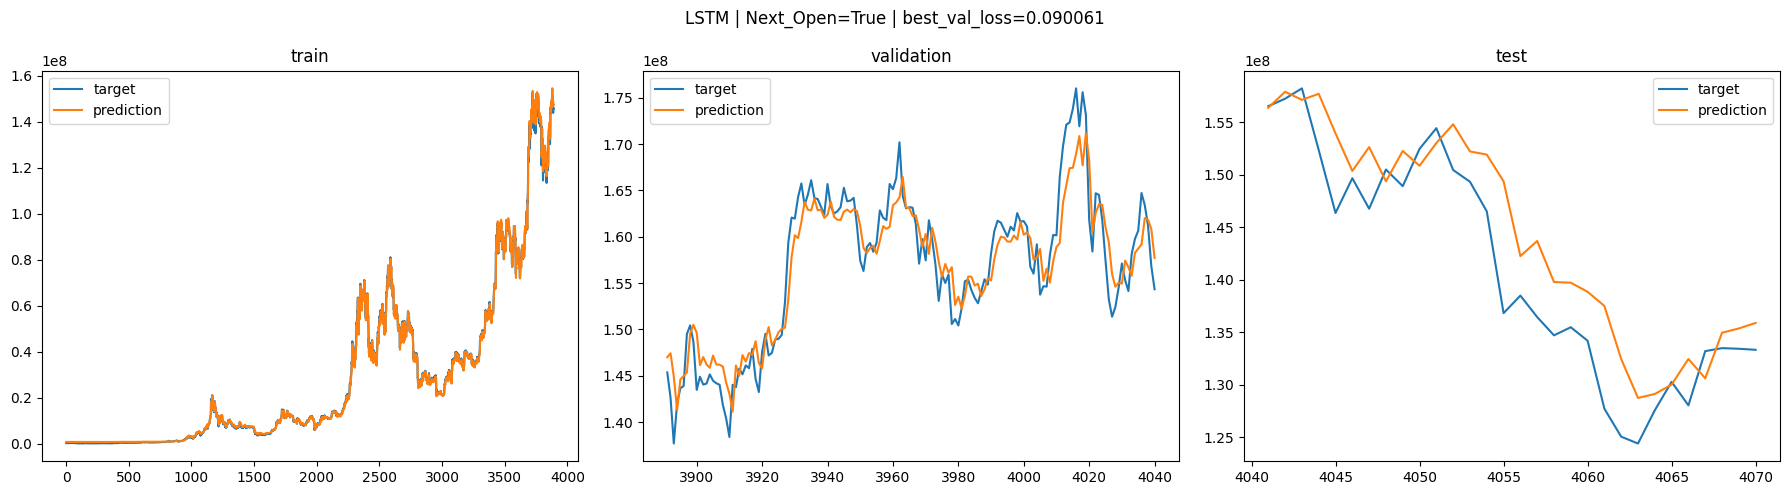

best_val_loss,▁
best_val_loss_so_far,█▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_wait,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▄▄▅▆▆▃▃▃▃▃▄▅▅▅▅▆▆▇▇█
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
grad_clip_max_norm,▁
lr,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇████████
n_input_features,▁
test_abs_error_mae_krw,▁
test_rmse_krw,▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[SelfAttention] Epoch    1 | train_loss=20.804763 | val_loss=241.219060 | best=241.219060 | wait=0/80 | lr=2.50e-06
[SelfAttention] Epoch   20 | train_loss=0.217380 | val_loss=1.714876 | best=1.714876 | wait=0/80 | lr=5.00e-05
[SelfAttention] Epoch   40 | train_loss=0.155714 | val_loss=0.755212 | best=0.614620 | wait=3/80 | lr=1.00e-04
[SelfAttention] Epoch   60 | train_loss=0.127630 | val_loss=0.535066 | best=0.392015 | wait=3/80 | lr=1.50e-04
[SelfAttention] Epoch   80 | train_loss=0.125988 | val_loss=0.505784 | best=0.296226 | wait=1/80 | lr=2.00e-04
[SelfAttention] Epoch  100 | train_loss=0.120445 | val_loss=0.261848 | best=0.261848 | wait=0/80 | lr=2.50e-04
[SelfAttention] Epoch  120 | train_loss=0.117981 | val_loss=0.525368 | best=0.259158 | wait=18/80 | lr=3.00e-04
[SelfAttention] Epoch  140 | train_loss=0.109359 | val_loss=0.206096 | best=0.202189 | wait=18/80 | lr=3.50e-04
[SelfAttention] Epoch  160 | train_loss=0.114402 | val_loss=0.429186 | best=0.202189 | wait=38/80 | lr=4.

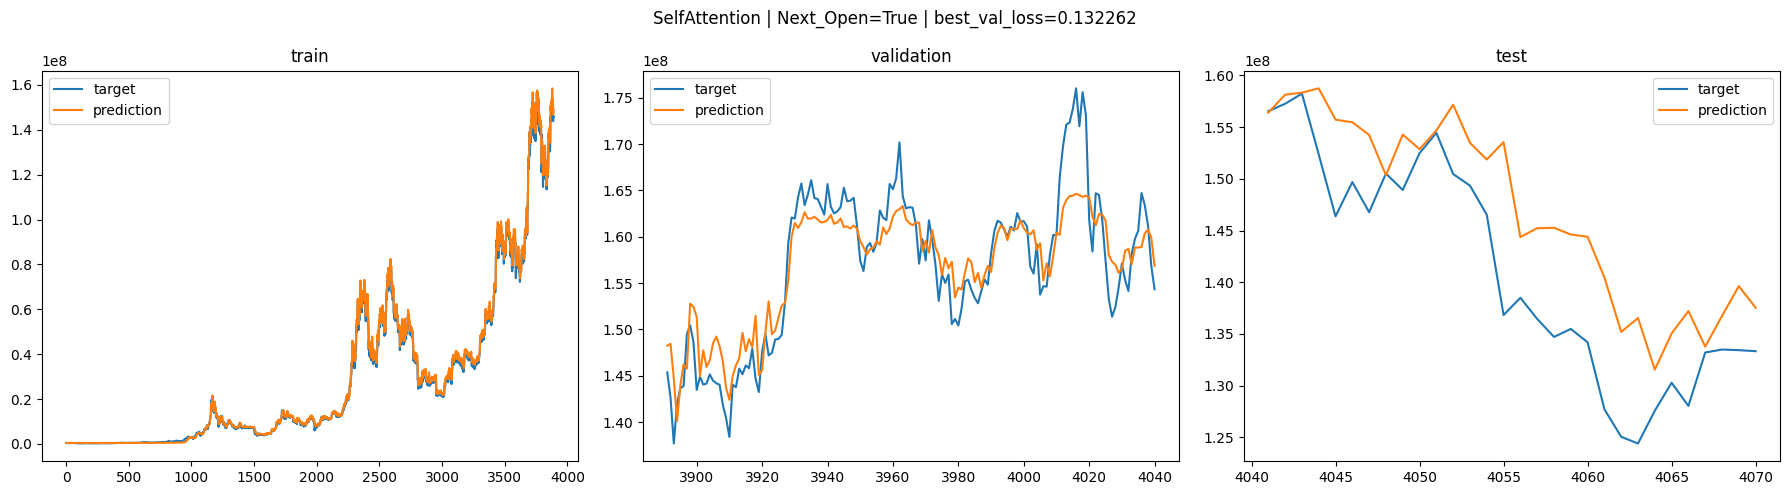

best_val_loss,▁
best_val_loss_so_far,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_wait,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▃▃▄▅▅▅▅▁▃▃▁▂▂▃▃▄▂▂▂▃▅▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
grad_clip_max_norm,▁
lr,▁▁▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇██████████████████
n_input_features,▁
test_abs_error_mae_krw,▁
test_rmse_krw,▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



##########################################################################################
LSTM vs Self-Attention (Regression, Next_Open=True) SUMMARY (FIXED)
- LSTM          | best_val_loss=0.090061 | test_mae_krw=3846552.250 | test_rmse_krw=4818339.500
- SelfAttention | best_val_loss=0.132262 | test_mae_krw=6026527.000 | test_rmse_krw=7369536.000
##########################################################################################


In [63]:
import os
import random
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30
ADD_NEXT_OPEN = True

BATCH_SIZE = 64
EPOCHS = 2000
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5

LSTM_LAYERS = 2
LSTM_HIDDEN = 256
LSTM_LINEAR_LAYERS = 3
LSTM_DROPOUT = 0.1

ATTN_D_MODEL = 128
ATTN_NHEAD = 8
ATTN_NUM_LAYERS = 2
ATTN_FF_DIM = 256
ATTN_DROPOUT = 0.2
ATTN_LINEAR_LAYERS = 2

WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EarlyStopping:
    def __init__(self, patience=30, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float("inf")
        self.best_state = None
        self.counter = 0

    def step(self, val_loss, model):
        improved = val_loss < (self.best - self.min_delta)
        if improved:
            self.best = val_loss
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
        stop = self.counter >= self.patience
        return stop, improved


def get_parser():
    p = argparse.ArgumentParser()
    p.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    p.add_argument("--wandb_project", type=str, default="btc_krw_problem3_self_attention_regression_fixed")
    p.add_argument("--wandb_entity", type=str, default=None)
    p.add_argument("--wandb_mode", type=str, default=None)
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--epochs", type=int, default=EPOCHS)
    p.add_argument("--batch_size", type=int, default=BATCH_SIZE)
    p.add_argument("--lr", type=float, default=LEARNING_RATE)
    p.add_argument("--print_every", type=int, default=20)
    return p


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(add_next_open: bool, sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={"Price": "Date"})

    base_cols = ["Close", "High", "Low", "Open", "Volume"]
    for col in base_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

    if add_next_open:
        df["Next_Open"] = df["Open"].shift(-1)
        cols = base_cols + ["Next_Open"]
    else:
        cols = base_cols

    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i : i + sequence_size].values)
        y_list.append(df_numeric.iloc[i + sequence_size]["Close"])

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.float32) / 1.0e7

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (
        X[:train_end],
        X[train_end:-test_size],
        X[-test_size:],
        y[:train_end],
        y[train_end:-test_size],
        y[-test_size:],
    )


class LSTMRegressor(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=LSTM_HIDDEN,
            num_layers=LSTM_LAYERS,
            batch_first=True,
            dropout=LSTM_DROPOUT if LSTM_LAYERS > 1 else 0.0,
        )
        layers = []
        for _ in range(max(0, LSTM_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(LSTM_HIDDEN, LSTM_HIDDEN), nn.ReLU(), nn.Dropout(LSTM_DROPOUT)]
        layers.append(nn.Linear(LSTM_HIDDEN, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


class SelfAttentionRegressor(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.in_proj = nn.Linear(n_input, ATTN_D_MODEL)
        self.pos_emb = nn.Parameter(torch.zeros(1, SEQUENCE_SIZE, ATTN_D_MODEL))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=ATTN_D_MODEL,
            nhead=ATTN_NHEAD,
            dim_feedforward=ATTN_FF_DIM,
            dropout=ATTN_DROPOUT,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=ATTN_NUM_LAYERS)
        self.norm = nn.LayerNorm(ATTN_D_MODEL)

        layers = []
        for _ in range(max(0, ATTN_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(ATTN_D_MODEL, ATTN_D_MODEL), nn.ReLU(), nn.Dropout(ATTN_DROPOUT)]
        layers.append(nn.Linear(ATTN_D_MODEL, 1))
        self.head = nn.Sequential(*layers)

        nn.init.normal_(self.pos_emb, mean=0.0, std=0.02)

    def forward(self, x):
        x = self.in_proj(x)
        x = x + self.pos_emb[:, : x.size(1), :]
        x = self.encoder(x)
        x = self.norm(x)

        x = x.mean(dim=1)
        return self.head(x)


def predict_all(test_model, add_next_open: bool, title: str):
    y_normalizer = 1.0e7

    X_train, X_validation, X_test, y_train, y_validation, y_test = get_btc_krw_data(
        add_next_open=add_next_open,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE,
    )

    train_ds = CryptoCurrencyDataset(X=X_train, y=y_train)
    val_ds = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_ds = CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [train_ds, val_ds, test_ds]
    dataset_labels = ["train", "validation", "test"]

    num = 0
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    test_model.eval()
    with torch.no_grad():
        for i in range(3):
            X_idx = []
            TARGET_Y = []
            PRED_Y = []
            for inp, tgt in dataset_list[i]:
                pred = test_model(inp.unsqueeze(0)).squeeze(-1).squeeze(-1)
                X_idx.append(num)
                TARGET_Y.append(float(tgt.item() * y_normalizer))
                PRED_Y.append(float(pred.item() * y_normalizer))
                num += 1

            axs[i].plot(X_idx, TARGET_Y, label="target")
            axs[i].plot(X_idx, PRED_Y, label="prediction")
            axs[i].set_title(dataset_labels[i])
            axs[i].legend()

    fig.suptitle(title)
    plt.tight_layout()
    return fig


def evaluate_test(model, X_test, y_test):
    model.eval()
    y_normalizer = 1.0e7
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).detach().cpu().numpy() * y_normalizer
        tgt = y_test.detach().cpu().numpy() * y_normalizer
    mae = float(np.mean(np.abs(pred - tgt)))
    rmse = float(np.sqrt(np.mean((pred - tgt) ** 2)))
    return mae, rmse


def build_warmup_cosine_scheduler(optimizer, total_steps: int, warmup_steps: int):
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + np.cos(np.pi * progress))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_and_eval(model_name, model, args, X_train, y_train, X_val, y_val, X_test, y_test, run=None):
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    total_steps = args.epochs * max(1, len(train_loader))
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = build_warmup_cosine_scheduler(optimizer, total_steps=total_steps, warmup_steps=warmup_steps)

    early = EarlyStopping(patience=80, min_delta=1e-6)

    global_step = 0

    for epoch in range(args.epochs):
        model.train()
        t_loss = 0.0

        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            pred = model(bx).squeeze(-1)
            loss = loss_fn(pred, by)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()

            scheduler.step()
            global_step += 1

            t_loss += loss.item()

        t_loss /= max(1, len(train_loader))

        model.eval()
        v_loss = 0.0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_pred = model(vx).squeeze(-1)
                v_loss += loss_fn(v_pred, vy).item()
        v_loss /= max(1, len(val_loader))

        stop, _ = early.step(v_loss, model)

        if (epoch == 0) or ((epoch + 1) % args.print_every == 0):
            lr_now = optimizer.param_groups[0]["lr"]
            print(
                f"[{model_name}] Epoch {epoch+1:4d} | train_loss={t_loss:.6f} | "
                f"val_loss={v_loss:.6f} | best={early.best:.6f} | wait={early.counter}/{early.patience} | lr={lr_now:.2e}"
            )

        if run is not None:
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "train_loss": t_loss,
                    "val_loss": v_loss,
                    "best_val_loss_so_far": early.best,
                    "early_wait": early.counter,
                    "lr": optimizer.param_groups[0]["lr"],
                }
            )

        if stop:
            print(f"[{model_name}] Early stop at epoch {epoch+1} (best_val_loss={early.best:.6f})")
            break

    model.load_state_dict(early.best_state)
    best_val = early.best

    model_cpu = model.cpu()
    test_mae, test_rmse = evaluate_test(model_cpu, X_test, y_test)

    fig = predict_all(
        test_model=model_cpu,
        add_next_open=ADD_NEXT_OPEN,
        title=f"{model_name} | Next_Open={ADD_NEXT_OPEN} | best_val_loss={best_val:.6f}",
    )

    metrics = {
        "best_val_loss": float(best_val),
        "test_abs_error_mae_krw": float(test_mae),
        "test_rmse_krw": float(test_rmse),
        "n_input_features": int(X_train.shape[-1]),
        "model_name": model_name,
        "add_next_open": bool(ADD_NEXT_OPEN),
        "attn_mean_pooling": True,
        "warmup_cosine": True,
        "grad_clip_max_norm": MAX_GRAD_NORM,
    }

    return model_cpu, fig, metrics


def init_wandb(args, run_name, config):
    if not (bool(args.wandb) and wandb is not None):
        return None
    mode = args.wandb_mode if args.wandb_mode is not None else "online"
    return wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        config=config,
        mode=mode,
    )


def main(args):
    seed_everything(args.seed)

    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        add_next_open=ADD_NEXT_OPEN,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE,
    )

    common_cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "is_regression": True,
        "add_next_open": bool(ADD_NEXT_OPEN),
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "learning_rate": args.lr,
        "weight_decay": WEIGHT_DECAY,
        "device": str(DEVICE),
        "features": int(X_train.shape[-1]),
        "warmup_ratio": WARMUP_RATIO,
        "max_grad_norm": MAX_GRAD_NORM,
    }

    results = []
    run_time = datetime.now().astimezone().strftime("%m%d_%H%M%S")

    for model_name in ["LSTM", "SelfAttention"]:
        if model_name == "LSTM":
            model = LSTMRegressor(n_input=X_train.shape[-1]).to(DEVICE)
            model_cfg = {
                "arch": "LSTM",
                "lstm_layers": LSTM_LAYERS,
                "hidden": LSTM_HIDDEN,
                "linear_layers": LSTM_LINEAR_LAYERS,
                "dropout": LSTM_DROPOUT,
            }
        else:
            model = SelfAttentionRegressor(n_input=X_train.shape[-1]).to(DEVICE)
            model_cfg = {
                "arch": "SelfAttention(TransformerEncoder)",
                "d_model": ATTN_D_MODEL,
                "nhead": ATTN_NHEAD,
                "num_layers": ATTN_NUM_LAYERS,
                "ff_dim": ATTN_FF_DIM,
                "dropout": ATTN_DROPOUT,
                "linear_layers": ATTN_LINEAR_LAYERS,
                "mean_pooling": True,
            }

        cfg = dict(common_cfg)
        cfg.update(model_cfg)

        run = init_wandb(args, run_name=f"p3_reg_{model_name}_fixed_{run_time}", config=cfg)

        model_cpu, fig, metrics = train_and_eval(
            model_name=model_name,
            model=model,
            args=args,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            X_test=X_test,
            y_test=y_test,
            run=run,
        )

        ckpt_path = f"/content/btc_krw_p3_reg_{model_name.lower()}_fixed.pt"
        torch.save(model_cpu.state_dict(), ckpt_path)

        fig_path = f"/content/predict_all_{model_name.lower()}_fixed.png"
        fig.savefig(fig_path, dpi=150, bbox_inches="tight")

        print(f"[{model_name}] Saved: {ckpt_path}")
        print(f"[{model_name}] Saved fig: {fig_path}")
        print(f"[{model_name}] Metrics: {metrics}")

        plt.show()

        if run is not None:
            wandb.log(metrics)
            wandb.log({f"predict_all_{model_name.lower()}_fixed": wandb.Image(fig)})
            wandb.summary.update(metrics)
            wandb.finish()

        plt.close(fig)
        results.append((model_name, metrics))

    print("\n" + "#" * 90)
    print("LSTM vs Self-Attention (Regression, Next_Open=True) SUMMARY (FIXED)")
    for name, m in results:
        print(
            f"- {name:13s} | best_val_loss={m['best_val_loss']:.6f} | "
            f"test_mae_krw={m['test_abs_error_mae_krw']:.3f} | test_rmse_krw={m['test_rmse_krw']:.3f}"
        )
    print("#" * 90)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


## 3-4 self-attention과 분류 모델 비교하기

- LSTM          | best_val_acc=0.6000 | best_val_loss=0.691459 | test_acc=0.6000 | test_loss=0.691884
- SelfAttention | best_val_acc=0.5333 | best_val_loss=0.688855 | test_acc=0.4333 | test_loss=0.694115

### 분석
회귀 모델과 비슷한 이유로 유사하게 나온 것 같다.

In [54]:
import os
import random
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

try:
    import wandb
except Exception:
    wandb = None

BTC_DATA_PATH = "/content/BTC_KRW_2025_11_30.csv"

SEQUENCE_SIZE = 21
VALIDATION_SIZE = 150
TEST_SIZE = 30
ADD_NEXT_OPEN = True

BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6

LSTM_LAYERS = 3
LSTM_HIDDEN = 256
LSTM_LINEAR_LAYERS = 1
LSTM_DROPOUT = 0.2

ATTN_D_MODEL = 256
ATTN_NHEAD = 8
ATTN_NUM_LAYERS = 2
ATTN_FF_DIM = 512
ATTN_DROPOUT = 0.2
ATTN_LINEAR_LAYERS = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_parser():
    p = argparse.ArgumentParser()
    p.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=True)
    p.add_argument("--wandb_project", type=str, default="btc_krw_problem3_self_attention_classification")
    p.add_argument("--wandb_entity", type=str, default=None)
    p.add_argument("--wandb_mode", type=str, default=None)
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--epochs", type=int, default=EPOCHS)
    p.add_argument("--batch_size", type=int, default=BATCH_SIZE)
    p.add_argument("--lr", type=float, default=LEARNING_RATE)
    p.add_argument("--print_every", type=int, default=10)
    return p


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_btc_krw_data(add_next_open: bool, sequence_size=SEQUENCE_SIZE, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE):
    df = pd.read_csv(BTC_DATA_PATH, skiprows=[1, 2])
    df = df.rename(columns={'Price': 'Date'})

    base_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in base_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

    if add_next_open:
        df["Next_Open"] = df["Open"].shift(-1)
        cols = base_cols + ["Next_Open"]
    else:
        cols = base_cols

    df_numeric = df[cols].dropna()

    X_list, y_list = [], []
    for i in range(len(df_numeric) - sequence_size):
        X_list.append(df_numeric.iloc[i:i + sequence_size].values)
        cur_close = df_numeric.iloc[i + sequence_size - 1]['Close']
        next_close = df_numeric.iloc[i + sequence_size]['Close']
        y_list.append(1 if next_close >= cur_close else 0)

    X = torch.tensor(np.array(X_list), dtype=torch.float32)
    y = torch.tensor(np.array(y_list), dtype=torch.long)

    train_end = len(X) - (validation_size + test_size)

    m, s = X[:train_end].mean(dim=0), X[:train_end].std(dim=0)
    X = (X - m) / (s + 1e-7)

    return (X[:train_end], X[train_end:-test_size], X[-test_size:],
            y[:train_end], y[train_end:-test_size], y[-test_size:])


class LSTMClassifier(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=LSTM_HIDDEN,
            num_layers=LSTM_LAYERS,
            batch_first=True,
            dropout=LSTM_DROPOUT if LSTM_LAYERS > 1 else 0.0
        )
        layers = []
        for _ in range(max(0, LSTM_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(LSTM_HIDDEN, LSTM_HIDDEN), nn.ReLU(), nn.Dropout(LSTM_DROPOUT)]
        layers.append(nn.Linear(LSTM_HIDDEN, 2))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.mlp(x)


class SelfAttentionClassifier(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.in_proj = nn.Linear(n_input, ATTN_D_MODEL)
        self.pos_emb = nn.Parameter(torch.zeros(1, SEQUENCE_SIZE, ATTN_D_MODEL))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=ATTN_D_MODEL,
            nhead=ATTN_NHEAD,
            dim_feedforward=ATTN_FF_DIM,
            dropout=ATTN_DROPOUT,
            batch_first=True,
            activation="gelu",
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=ATTN_NUM_LAYERS)
        self.norm = nn.LayerNorm(ATTN_D_MODEL)

        layers = []
        for _ in range(max(0, ATTN_LINEAR_LAYERS - 1)):
            layers += [nn.Linear(ATTN_D_MODEL, ATTN_D_MODEL), nn.ReLU(), nn.Dropout(ATTN_DROPOUT)]
        layers.append(nn.Linear(ATTN_D_MODEL, 2))
        self.head = nn.Sequential(*layers)

        nn.init.normal_(self.pos_emb, mean=0.0, std=0.02)

    def forward(self, x):
        x = self.in_proj(x)
        x = x + self.pos_emb[:, :x.size(1), :]
        x = self.encoder(x)
        x = self.norm(x)
        x = x[:, -1, :]
        return self.head(x)


def eval_cls(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        loss = nn.CrossEntropyLoss()(logits, y).item()
        pred = torch.argmax(logits, dim=1)
        acc = (pred == y).float().mean().item()
    return float(acc), float(loss)


def train_and_eval(model_name, model, args, X_train, y_train, X_val, y_val, X_test, y_test, run=None):
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=args.batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = -1.0
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(args.epochs):
        model.train()
        t_loss = 0.0
        t_corr = 0
        n = 0
        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            logits = model(bx)
            loss = loss_fn(logits, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_corr += (torch.argmax(logits, dim=1) == by).sum().item()
            n += by.size(0)
        t_loss /= max(1, len(train_loader))
        t_acc = t_corr / max(1, n)

        model.eval()
        v_loss = 0.0
        v_corr = 0
        vn = 0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(DEVICE), vy.to(DEVICE)
                v_logits = model(vx)
                v_loss += loss_fn(v_logits, vy).item()
                v_corr += (torch.argmax(v_logits, dim=1) == vy).sum().item()
                vn += vy.size(0)
        v_loss /= max(1, len(val_loader))
        v_acc = v_corr / max(1, vn)

        improved = False
        if v_acc > best_val_acc + 1e-12:
            improved = True
        elif abs(v_acc - best_val_acc) <= 1e-12 and v_loss < best_val_loss:
            improved = True

        if improved:
            best_val_acc = float(v_acc)
            best_val_loss = float(v_loss)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if (epoch == 0) or ((epoch + 1) % args.print_every == 0):
            print(f"[{model_name}] Epoch {epoch+1:3d} | train_acc={t_acc:.4f} train_loss={t_loss:.6f} | "
                  f"val_acc={v_acc:.4f} val_loss={v_loss:.6f}")

        if run is not None:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": t_loss,
                "val_loss": v_loss,
                "train_acc": t_acc,
                "val_acc": v_acc
            })

    model.load_state_dict(best_state)
    model_cpu = model.cpu()

    test_acc, test_loss = eval_cls(model_cpu, X_test, y_test)

    metrics = {
        "best_val_acc": float(best_val_acc),
        "best_val_loss": float(best_val_loss),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
        "n_input_features": int(X_train.shape[-1]),
        "model_name": model_name,
        "add_next_open": True,
    }

    return model_cpu, metrics


def init_wandb(args, run_name, config):
    if not (bool(args.wandb) and wandb is not None):
        return None
    mode = args.wandb_mode if args.wandb_mode is not None else "online"
    return wandb.init(
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=run_name,
        config=config,
        mode=mode
    )


def main(args):
    seed_everything(args.seed)

    X_train, X_val, X_test, y_train, y_val, y_test = get_btc_krw_data(
        add_next_open=ADD_NEXT_OPEN,
        sequence_size=SEQUENCE_SIZE,
        validation_size=VALIDATION_SIZE,
        test_size=TEST_SIZE
    )

    common_cfg = {
        "sequence_size": SEQUENCE_SIZE,
        "validation_size": VALIDATION_SIZE,
        "test_size": TEST_SIZE,
        "is_regression": False,
        "add_next_open": True,
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "learning_rate": args.lr,
        "weight_decay": WEIGHT_DECAY,
        "device": str(DEVICE),
        "features": int(X_train.shape[-1]),
    }

    results = []

    run_time = datetime.now().astimezone().strftime("%m%d_%H%M%S")

    for model_name in ["LSTM", "SelfAttention"]:
        if model_name == "LSTM":
            model = LSTMClassifier(n_input=X_train.shape[-1]).to(DEVICE)
            model_cfg = {
                "arch": "LSTM",
                "lstm_layers": LSTM_LAYERS,
                "hidden": LSTM_HIDDEN,
                "linear_layers": LSTM_LINEAR_LAYERS,
                "dropout": LSTM_DROPOUT,
            }
        else:
            model = SelfAttentionClassifier(n_input=X_train.shape[-1]).to(DEVICE)
            model_cfg = {
                "arch": "SelfAttention(TransformerEncoder)",
                "d_model": ATTN_D_MODEL,
                "nhead": ATTN_NHEAD,
                "num_layers": ATTN_NUM_LAYERS,
                "ff_dim": ATTN_FF_DIM,
                "dropout": ATTN_DROPOUT,
                "linear_layers": ATTN_LINEAR_LAYERS,
            }

        cfg = dict(common_cfg)
        cfg.update(model_cfg)

        run = init_wandb(args, run_name=f"p3_cls_{model_name}_nextopen_{run_time}", config=cfg)

        model_cpu, metrics = train_and_eval(
            model_name=model_name,
            model=model,
            args=args,
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            run=run
        )

        ckpt_path = f"/content/btc_krw_p3_cls_{model_name.lower()}_nextopen.pt"
        torch.save(model_cpu.state_dict(), ckpt_path)

        print(f"[{model_name}] Saved: {ckpt_path}")
        print(f"[{model_name}] Metrics: {metrics}")

        if run is not None:
            wandb.log(metrics)
            wandb.summary.update(metrics)
            wandb.finish()

        results.append((model_name, metrics))

    print("\n" + "#" * 90)
    print("LSTM vs Self-Attention (Classification, Next_Open=True) SUMMARY")
    for name, m in results:
        print(f"- {name:13s} | best_val_acc={m['best_val_acc']:.4f} | best_val_loss={m['best_val_loss']:.6f} | "
              f"test_acc={m['test_acc']:.4f} | test_loss={m['test_loss']:.6f}")
    print("#" * 90)


if __name__ == "__main__":
    parser = get_parser()
    args = parser.parse_args(args=[])
    main(args)


[LSTM] Epoch   1 | train_acc=0.5258 train_loss=0.691582 | val_acc=0.5467 val_loss=0.692482
[LSTM] Epoch  10 | train_acc=0.5281 train_loss=0.691065 | val_acc=0.5067 val_loss=0.691326
[LSTM] Epoch  20 | train_acc=0.5261 train_loss=0.691043 | val_acc=0.5067 val_loss=0.691679
[LSTM] Epoch  30 | train_acc=0.5284 train_loss=0.690907 | val_acc=0.5067 val_loss=0.691284
[LSTM] Epoch  40 | train_acc=0.5320 train_loss=0.690957 | val_acc=0.5067 val_loss=0.691840
[LSTM] Epoch  50 | train_acc=0.5269 train_loss=0.690962 | val_acc=0.5067 val_loss=0.691702
[LSTM] Epoch  60 | train_acc=0.5269 train_loss=0.690941 | val_acc=0.5067 val_loss=0.692113
[LSTM] Epoch  70 | train_acc=0.5258 train_loss=0.690891 | val_acc=0.5067 val_loss=0.691432
[LSTM] Epoch  80 | train_acc=0.5302 train_loss=0.690794 | val_acc=0.5067 val_loss=0.690890
[LSTM] Epoch  90 | train_acc=0.5271 train_loss=0.690907 | val_acc=0.5333 val_loss=0.690279
[LSTM] Epoch 100 | train_acc=0.5323 train_loss=0.690569 | val_acc=0.5267 val_loss=0.688515

best_val_acc,▁
best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
n_input_features,▁
test_acc,▁
test_loss,▁
train_acc,▂▂▅▃▂▇▅▄▄▆▆▄▂▅▄▅▂▂██▇▄▄▆▅▇▁▃▅▆▇▄▄█▄▄▆▇▅█
train_loss,▆▇▇▅█▃▆▃▅▅▄▅▃▄▃▄▃▃▃▄▃▄▃▄▅▆▃▃▄▃▄▄▂▂▄▁▂▃▂▁
val_acc,▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁█▅▆
val_loss,▄▆▅▅▆▅█▅▆▆▇▇▆▆▇▇▇▇▆▇▆▇█▇▆▇▆▆▇▇▆▆▇▆▆▅▄▃▅▁
add_next_open,True


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[SelfAttention] Epoch   1 | train_acc=0.5137 train_loss=0.712618 | val_acc=0.5333 val_loss=0.688855
[SelfAttention] Epoch  10 | train_acc=0.5022 train_loss=0.699904 | val_acc=0.5333 val_loss=0.691948
[SelfAttention] Epoch  20 | train_acc=0.5207 train_loss=0.694534 | val_acc=0.5067 val_loss=0.694479
[SelfAttention] Epoch  30 | train_acc=0.5271 train_loss=0.691973 | val_acc=0.5200 val_loss=0.697071
[SelfAttention] Epoch  40 | train_acc=0.5400 train_loss=0.691252 | val_acc=0.4533 val_loss=0.699748
[SelfAttention] Epoch  50 | train_acc=0.5315 train_loss=0.691190 | val_acc=0.5133 val_loss=0.718052
[SelfAttention] Epoch  60 | train_acc=0.5346 train_loss=0.690277 | val_acc=0.4333 val_loss=0.706597
[SelfAttention] Epoch  70 | train_acc=0.5454 train_loss=0.688073 | val_acc=0.5067 val_loss=0.705289
[SelfAttention] Epoch  80 | train_acc=0.5502 train_loss=0.684462 | val_acc=0.5000 val_loss=0.699618
[SelfAttention] Epoch  90 | train_acc=0.5687 train_loss=0.678093 | val_acc=0.5133 val_loss=0.696927


best_val_acc,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
n_input_features,▁
test_acc,▁
test_loss,▁
train_acc,▂▂▁▃▄▃▃▃▁▃▃▄▄▄▄▅▄▃▄▄▄▄▃▄▅▅▄▅▄▅▆▇▆▆▇█▇█▇▇
train_loss,██▆▆▆▆▆▅▆▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▄▃▂▂▂▂▁▁
val_acc,▆▆▆█▄▆▆▆▆▆▅▃▃▆▄▆▆▃▃▁▆▅▄▁▅▆▂▁▄▆▃▁▄▅▃▅▅▆▁▃
val_loss,▂▁▁▄▂▂▃▅▂▃▃▄▃▃▃▄▅▅▆▅▆▇▅█▆▅▅▅▅▃▄▅▄▄▄▄▃▄▄▃
add_next_open,True



##########################################################################################
LSTM vs Self-Attention (Classification, Next_Open=True) SUMMARY
- LSTM          | best_val_acc=0.6000 | best_val_loss=0.691459 | test_acc=0.6000 | test_loss=0.691884
- SelfAttention | best_val_acc=0.5333 | best_val_loss=0.688855 | test_acc=0.4333 | test_loss=0.694115
##########################################################################################
